In [360]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os

Populating the interactive namespace from numpy and matplotlib


C:\Users\nedge\New folder\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'f', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Initialisation?

In [361]:
##<script>
##  jQuery(document).ready(function($) {  
##  
##  $(window).on('load', function(){
##    $('#preloader').fadeOut('slow',function(){$(this).remove();});
##  });
##  
##  });
##</script>
##
##<style type="text/css">
##  div#preloader { position: fixed; 
##      left: 0; 
##      top: 0; 
##      z-index: 999; 
##      width: 100%; 
##      height: 100%; 
##      overflow: visible; 
##      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center; 
##  }
##
##</style>
##
##<div id="preloader">
##
##</div>

# Loading Pilot Data
## Load Eyetracker reports from Eyelink Data Viewer
### Loading Interest Area (IA) and Saccade (Sacc) reports

In [362]:
#Select path for IA and Sacc
pathIA ="P22_to_P51IAReport.xls"
pathSacc ="P22_to_P51SacReport.xls"
# load csv for IA and Sacc
pX_IAdata = [pd.read_csv(pathIA, sep="\t")]
pX_SACCdata = [pd.read_csv(pathSacc, sep="\t")]
# Concatenate to generate frames
IAdata = pd.concat(pX_IAdata)
SACCdata = pd.concat(pX_SACCdata)
#print(IAdata)

#### DF w/ interest area information

In [363]:
#IAdata

#### SF w/ saccade information

In [364]:
#SACCdata

In [365]:
participant = IAdata['DATA_FILE'].unique()
participant_names = IAdata['DATA_FILE'].unique()

#Extract just names of participant (for folder name in future steps)
#yy=0
#for xx in participant_names:
    #participant_names[yy]=xx.rstrip(".edf")
    #yy+=1
print (participant_names)

percpart = participant_names #take participants who had DeltaVal as a percentage

trial_n = IAdata['Trial_Index_'].unique()

print("Number of participants:", len(participant))
print ("Number of trials:", len(trial_n))

['P22.edf' 'P23.edf' 'P24.edf' 'P25.edf' 'P26.edf' 'P27.edf' 'P28.edf'
 'P29.edf' 'P30.edf' 'P31.edf' 'P32.edf' 'P33.edf' 'P34.edf' 'P35.edf'
 'P36.edf' 'P37.edf' 'P38.edf' 'P39.edf' 'P40.edf' 'P41.edf' 'P42.edf'
 'P43.edf' 'P44.edf' 'P45.edf' 'P46.edf' 'P47.edf' 'P48.edf' 'P49.edf'
 'P50.edf' 'P51.edf']
Number of participants: 30
Number of trials: 280


## Calculate GSF for each participant and trial

In [366]:
def participant_densities(data, var, xlim=(0,100), rug=True):
    # a counter that tells us where a given participant's data should be plotted
    order = 1

    # a list of all the participants in the dataset
    participants = data.loc[:, 'Part'].unique()

    # defining the figure size
    sns.set_style('white')
    fig = figure(figsize=(15,15))

    for x in participants:
        # defining the sub figures
            sub={}
            sub['%s' % x] = plt.subplot(len(participants)/2, 3, order)
            sns.kdeplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x], shade= True) #
            #if rug==True:
            #    sns.rugplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x])
            sub['%s' % x].set_title('participant %s' % x)
            #sub['%s' % x].set_xlim(xlim)
            order += 1

In [369]:
i=0
GSF_matrix = []

#Run for each individual participant
for i in range(len(percpart)):
    #Extract the number of trials for this participant
    #pX_indSubj = SACCdata.loc[(SACCdata['DATA_FILE']==participant[i]) & (SACCdata['trial_type']== 'Experiment')]
    #Add number of trials for the experiment
    #trial_n = pX_indSubj['trial'].unique()
    trial_n = range(240)
    for  j in range(len(trial_n)):
            # extract saccade data for this participant
            GSF_data=SACCdata.loc[(SACCdata['DATA_FILE']==percpart[i]) & (SACCdata['TRIAL_INDEX']== j) & (SACCdata['trial_type']== 'Experiment')]


            # considered direct glance transition between IA 1 (left) and IA 2 (right)
            booatstart_p1=GSF_data['CURRENT_SAC_START_INTEREST_AREA_ID'] == '2'
            booatend_p1=GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'] == '1'
            booatstart_p2=GSF_data['CURRENT_SAC_START_INTEREST_AREA_ID'] == '1'
            booatend_p2=GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'] == '2'            
            
            #Count shift only if the saccade goes from one area to the other (right to left or left to right item)
            shifts_p1= booatstart_p1 & booatend_p1
            shifts_p2= booatstart_p2 & booatend_p2

            shifts_total = shifts_p1 | shifts_p2
            #Count the total number of shifts in this trial
            trialGSF = sum(shifts_total*1)
            
            #Extract the region (left or right) for the last fixation
            go_back = 1
            tail_fix = GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'].tail(go_back)  
            
            # If we have not fixation information we don't skip it, we fill with zeros
            #if GSF_data.empty:
                #print ('skipped: participant:',participant[i],'TRIAL_INDEX',j+1)
                #continue
            
            ## If the sequence is empty, we assign 0 to tail
            if tail_fix.empty:
                tail_fix = 0
            else:
                tail_fix = tail_fix.values[0]
            
            while ('.'== tail_fix) | ('3'== tail_fix):
                go_back = go_back + 1
                tail_fix = GSF_data['CURRENT_SAC_END_INTEREST_AREA_ID'].tail(go_back)
                #Since tail gets the last n subjects we need to just pick the one on top
                tail_fix_aux = tail_fix.values
                tail_fix = tail_fix_aux[0]
            
            #add GSF trial info to a new row if the matrix
            GSF_matrix.append([percpart[i], j+1, trialGSF, tail_fix]) #trial number, trial GSF, last_fixation

# Calculate DDT for each participant and trial
## Extract measures of dwelll time (DT) Per interest area (IA) in each trial

In [368]:
# IA1: left item ; IA2 : right item ; IA3: condition icon
IA1_data=IAdata.loc[(IAdata['DATA_FILE']==percpart[i]) & (IAdata['Trial_Index_']== j+1) & (IAdata['IA_ID']== 1) & (IAdata['trial_type']== 'Experiment')]
IA2_data=IAdata.loc[(IAdata['DATA_FILE']==percpart[i]) & (IAdata['Trial_Index_']== j+1) & (IAdata['IA_ID']== 2) & (IAdata['trial_type']== 'Experiment')]
IA3_data=IAdata.loc[(IAdata['DATA_FILE']==percpart[i]) & (IAdata['Trial_Index_']== j+1) & (IAdata['IA_ID']== 3) & (IAdata['trial_type']== 'Experiment')]

print ("Information contained in IA report ")
#list(IA1_data)
#print(IA1_data)

Information contained in IA report 


In [370]:
i=0
DDT_matrix = []


#Extract information for each participant. Behavioural parameters also extracted from this report.
for i in range(len(percpart)):
    #pX_indSubj = IAdata.loc[(IAdata['DATA_FILE']==participant[i]) & (pX_IAdata['trial_type']== 'Experiment')]
    #Add number of trials for the experiment
    #trial_n = pX_indSubj['trial'].unique()
    trial_n = range(240)
    for  j in range(len(trial_n)):
            #Extract DT information for the trial IA1 :left ; IA2 : right
            IA1_data=IAdata.loc[(IAdata['DATA_FILE']==percpart[i]) & (IAdata['Trial_Index_']== j+41) & (IAdata['IA_ID']== 1) & (IAdata['trial_type']== 'Experiment')]
            IA2_data=IAdata.loc[(IAdata['DATA_FILE']==percpart[i]) & (IAdata['Trial_Index_']== j+41) & (IAdata['IA_ID']== 2) & (IAdata['trial_type']== 'Experiment')]
            #print(IA1_data)

            #Save additional behavioural parameters
            trial_PairID = pd.to_numeric(IA1_data['pairid'].values[0])
            #trial_LL_Item = IA1_data['LL_Item'][0]
            trial_LL_Value = pd.to_numeric(IA1_data['DOTS_LEFT'].values[0])
            #trial_LR_Item = IA1_data['LR_Item'][0]
            trial_LR_Value = pd.to_numeric(IA1_data['DOTS_RIGHT'].values[0])
            if IA1_data['CHOICE_KEYPRESS'].values[0] == 'm':
                trial_ChosenItm = 1  # 1: selected item is Right ; 0: selected item is Left
            else: 
                trial_ChosenItm = 0
            trial_ChoiceRT = IA1_data['CHOICE_RT'].values[0]
            trial_Conf = IA1_data['CONF'].values[0]
            trial_ConfRT = IA1_data['CONF_RT'].values[0]
            trial_BlockCond = IA1_data['moreorless'].values[0] #1:like 2: dislike
            
            #Calculate DDT values for the trial
            IA_1_DT = IA1_data['IA_DWELL_TIME'].values[0]
            IA_2_DT = IA2_data['IA_DWELL_TIME'].values[0]
            
            # If participant did not spend time in the Interest Areas we should skip it
            if (IA_1_DT == 0) & (IA_2_DT == 0):
                print(IA_1_DT == 0 & IA_2_DT == 0)
                print ('area1',IA_1_DT,'area2',IA_2_DT)
                print ('skipped: participant:',i,'Trial_Index_',j+1)
                continue
            
            trialDDT = -IA_1_DT + IA_2_DT # since DDT_GSF_Zvalue_trial_part_v2.csv we use RIGHT - LEFT
            
            #define matrix DDT + behavioural parameters
            DDT_matrix.append([i+1, j+1, trial_PairID, trial_LL_Value, trial_LR_Value, trial_ChosenItm, trial_ChoiceRT, trial_Conf, trial_ConfRT, trial_BlockCond, trialDDT,IA_1_DT, IA_2_DT]) 

#list(DDT_matrix)

True
area1 0 area2 0
skipped: participant: 13 Trial_Index_ 10


#### Stack both results (GSF and DDT) matrices together

In [372]:
print(shape(GSF_matrix))
GSF_matrix_edit = numpy.delete(GSF_matrix, (3129), axis=0)
print(shape(GSF_matrix_edit))
shape(DDT_matrix)

(7200, 4)
(7199, 4)


(7199, 13)

In [373]:
DDT_GSF_trial = np.column_stack((DDT_matrix,GSF_matrix_edit))

In [374]:
print(DDT_GSF_trial[100])

['1' '101' '33' '75' '80' '1' '4156.099' '94' '1382.8929999999998' 'LESS'
 '775' '1467' '2242' 'P22.edf' '101' '4' '1']


#### Delete redundant column names

In [375]:
DDT_GSF_trial = np.delete(DDT_GSF_trial, 14, 1) # remove TRIAL_INDEX redundant columns

print(DDT_GSF_trial[100])

['1' '101' '33' '75' '80' '1' '4156.099' '94' '1382.8929999999998' 'LESS'
 '775' '1467' '2242' 'P22.edf' '4' '1']


In [376]:
DDT_GSF_trial = np.delete(DDT_GSF_trial, 13, 1) # remove subject_name redundant columns
print(DDT_GSF_trial[100])
print(shape(DDT_GSF_trial))

['1' '101' '33' '75' '80' '1' '4156.099' '94' '1382.8929999999998' 'LESS'
 '775' '1467' '2242' '4' '1']
(7199, 15)


#### Insert headers

In [377]:
DDT_GSF_head = np.insert(DDT_GSF_trial,  0, np.array(('Part', 'TrialN', 'PairID', 'LValue', 'RValue', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'lIA_DT', 'rIA_DT', 'tGSF','lastFixat')), axis=0)

# 5 Display Summary Measures

In [378]:
#Generate DataFrame for new summary table                                              
DataFrameSum1=pd.DataFrame(DDT_GSF_head,columns=['Part', 'TrialN', 'PairID', 'LValue', 'RValue', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'lIA_DT', 'rIA_DT', 'tGSF','lastFixat'])
DataFrameSum1=DataFrameSum1.drop(DataFrameSum1.index[0])
pd.DataFrame.head(DataFrameSum1)


Part TrialN PairID LValue RValue ChosenITM            ChoiceRT Conf  \
1    1      1     49    110    131         0            4261.735   74   
2    1      2     13     47     50         1            3559.258   54   
3    1      3     16     50     44         1  3754.4640000000004   64   
4    1      4      7     57     50         0            2431.751   84   
5    1      5     18     42     50         0            2199.342   44   

               ConfRT BlockCond  tDDT lIA_DT rIA_DT tGSF lastFixat  
1  1584.9660000000001      LESS  -704   2114   1410    0         0  
2  1864.3870000000002      LESS     8   1332   1340    0         0  
3  3778.8070000000002      LESS    38   1272   1310    0         0  
4            3064.179      LESS  -587   1261    674    0         0  
5            2850.845      LESS  -749   1291    542    0         0

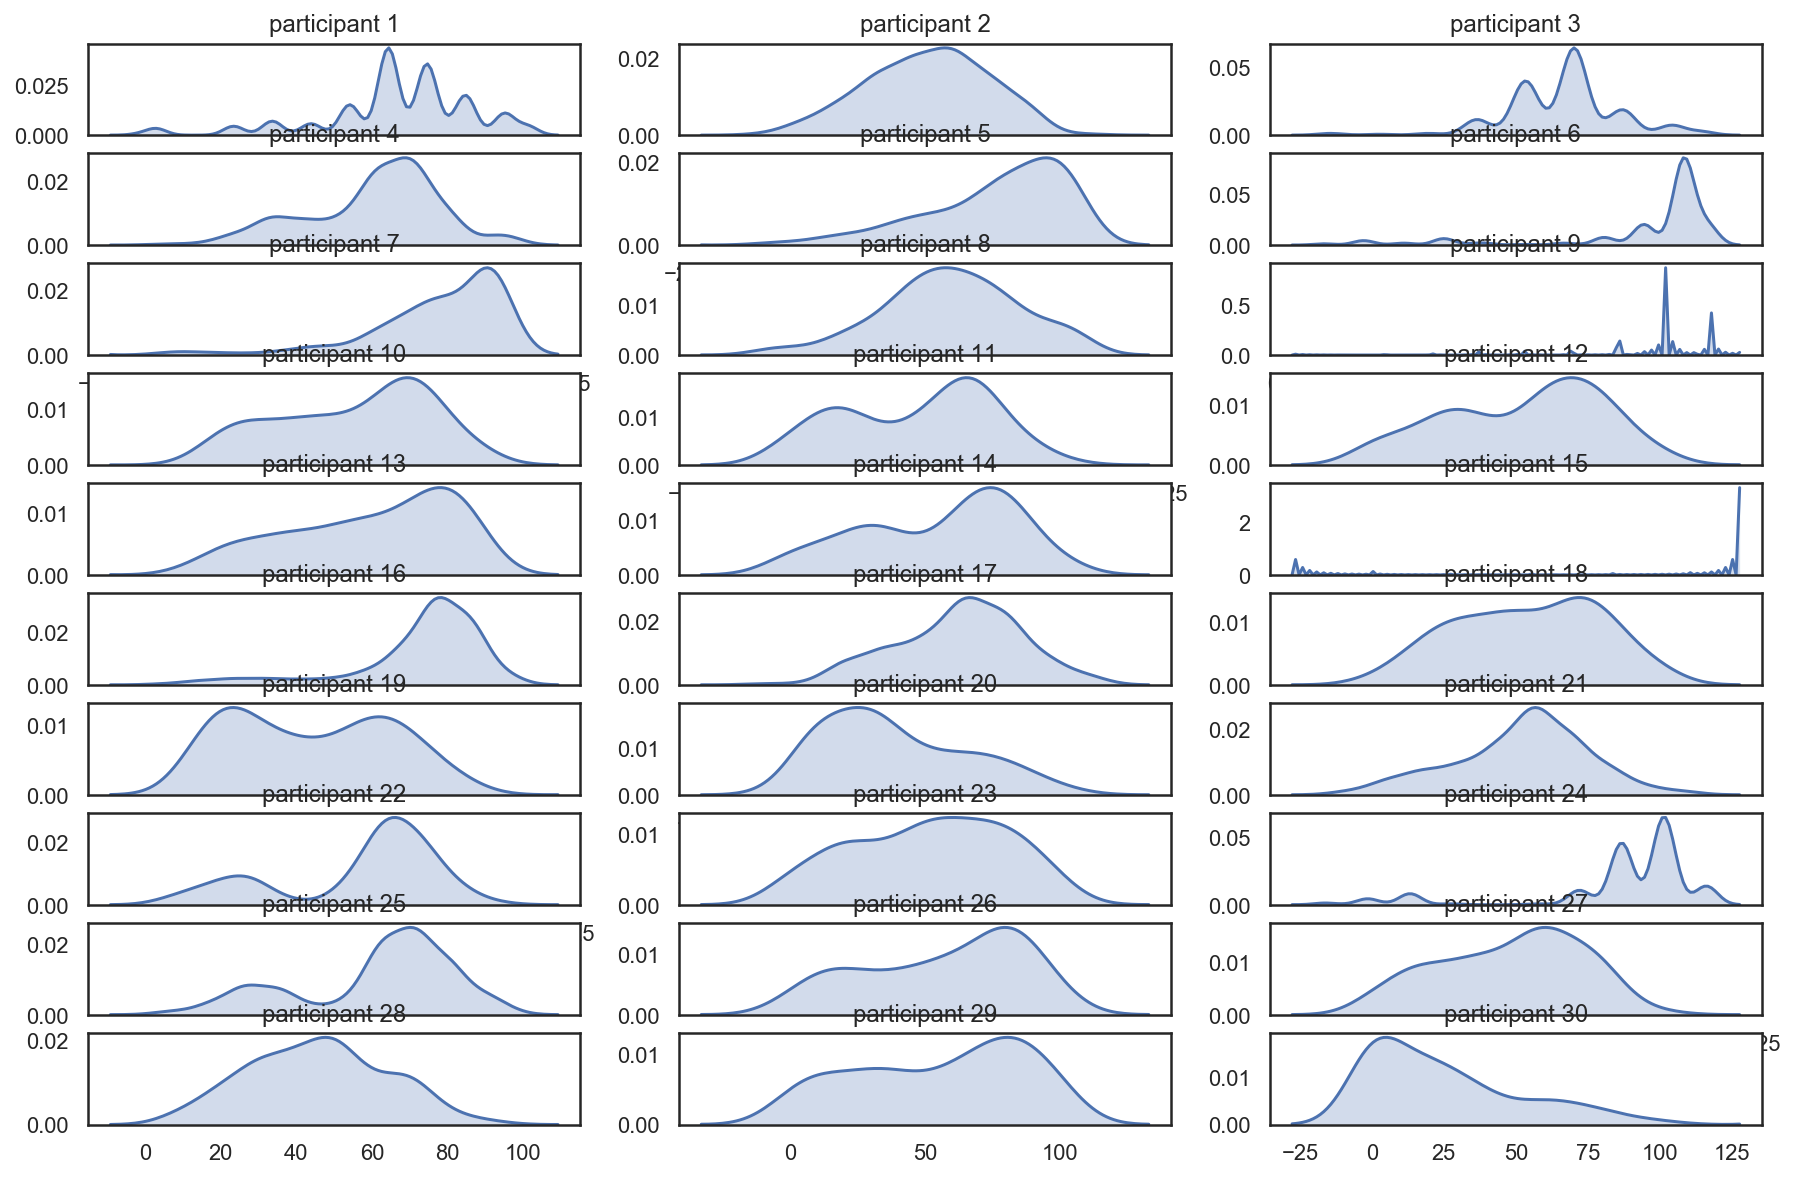

In [379]:
participant_densities(DataFrameSum1,'Conf')

### Choice RT Distributions

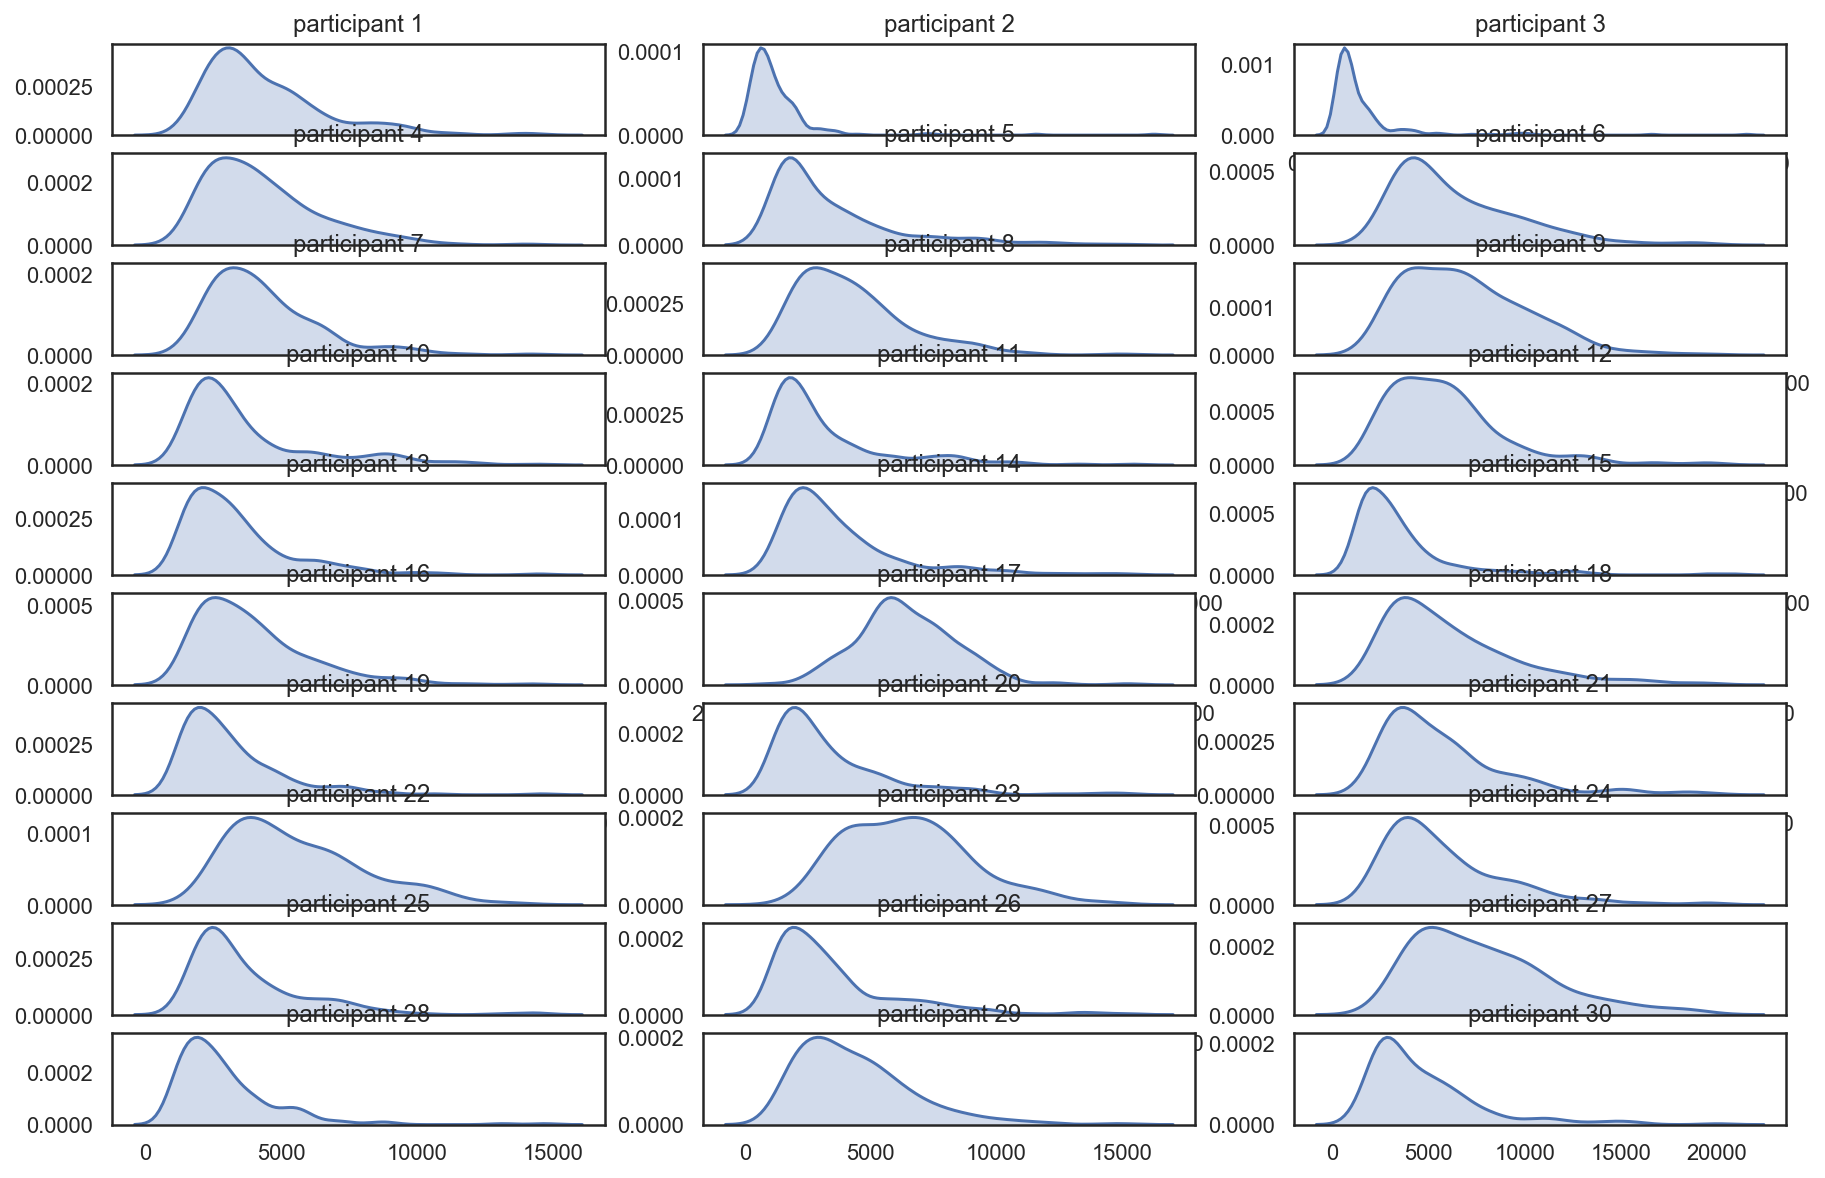

In [380]:
participant_densities(DataFrameSum1,'ChoiceRT')

## Trial DDT Distributions

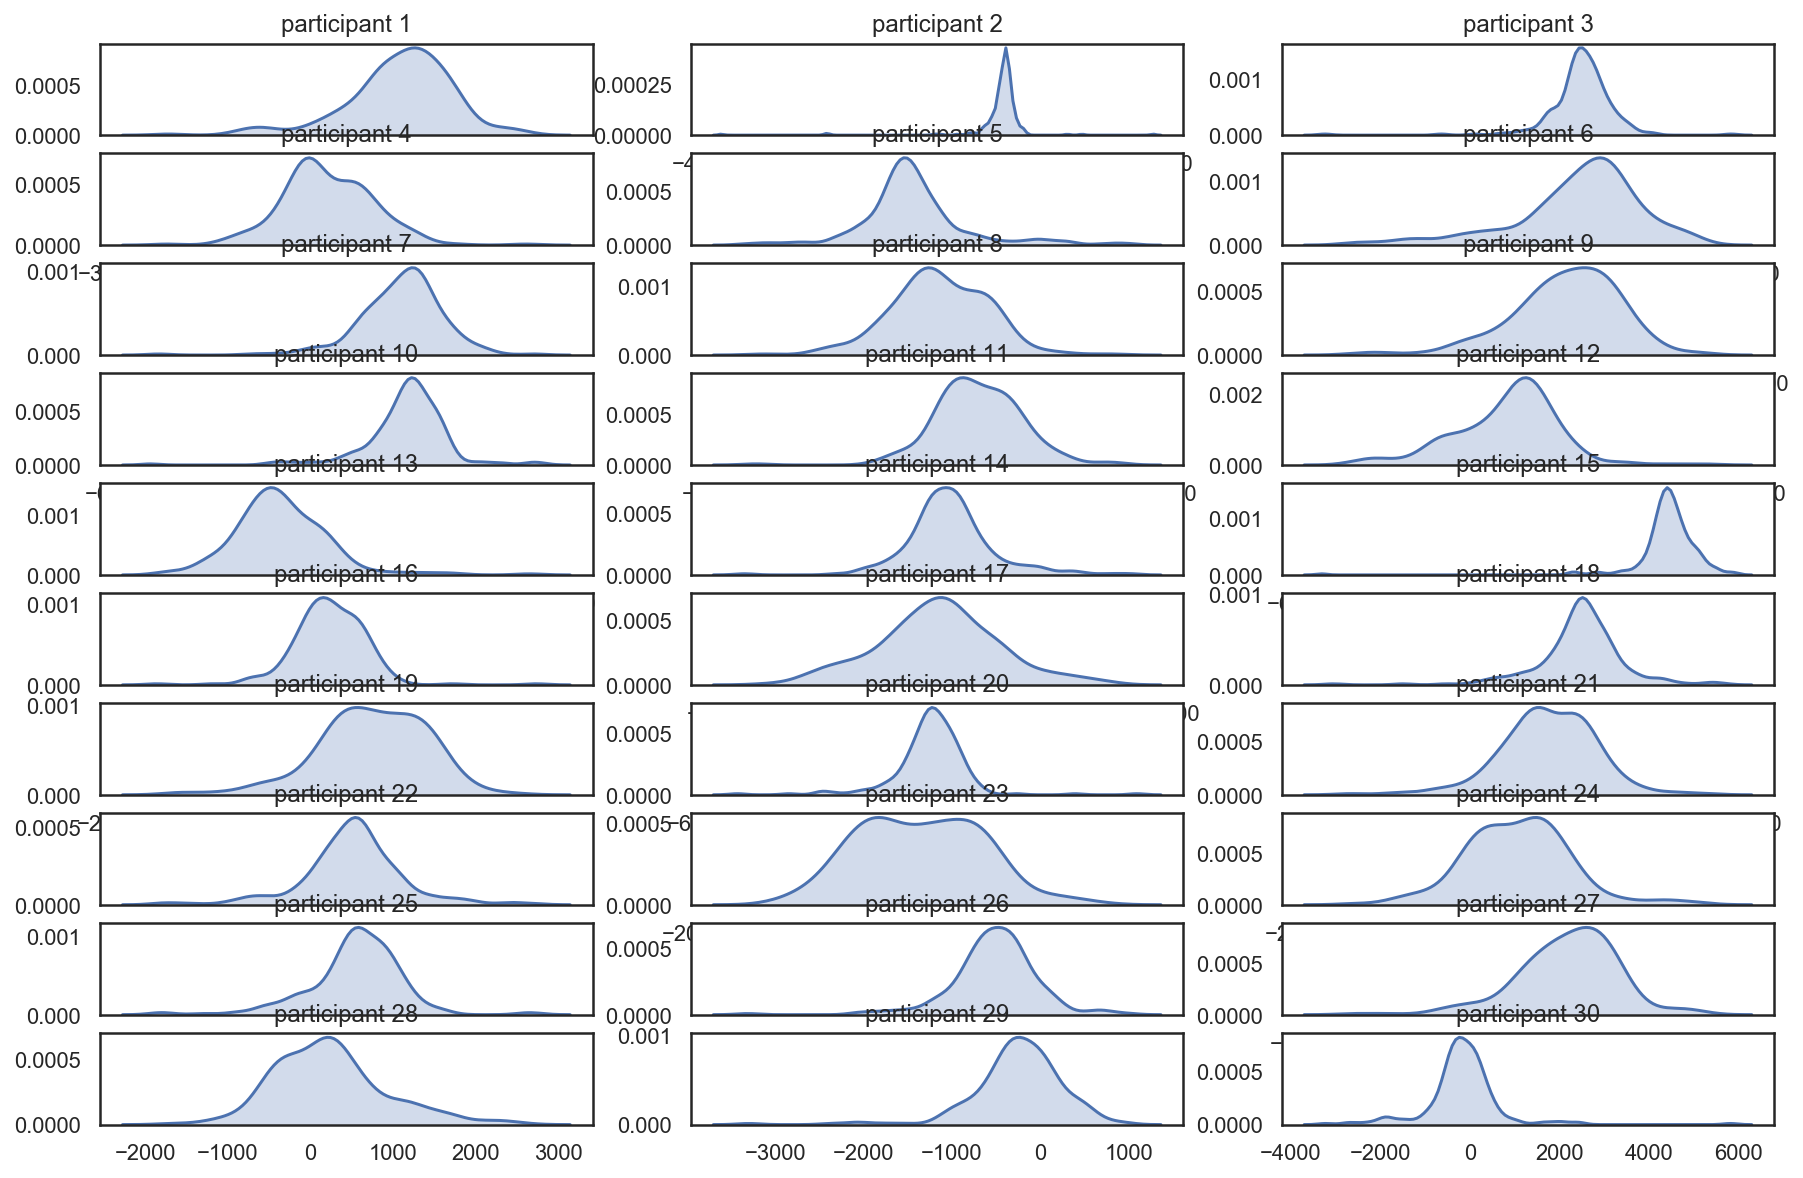

In [381]:
participant_densities(DataFrameSum1,'tDDT')

### Left and right dot density distributions
#### This shows that Left and Right items are balanced in P4 & 5 as expected

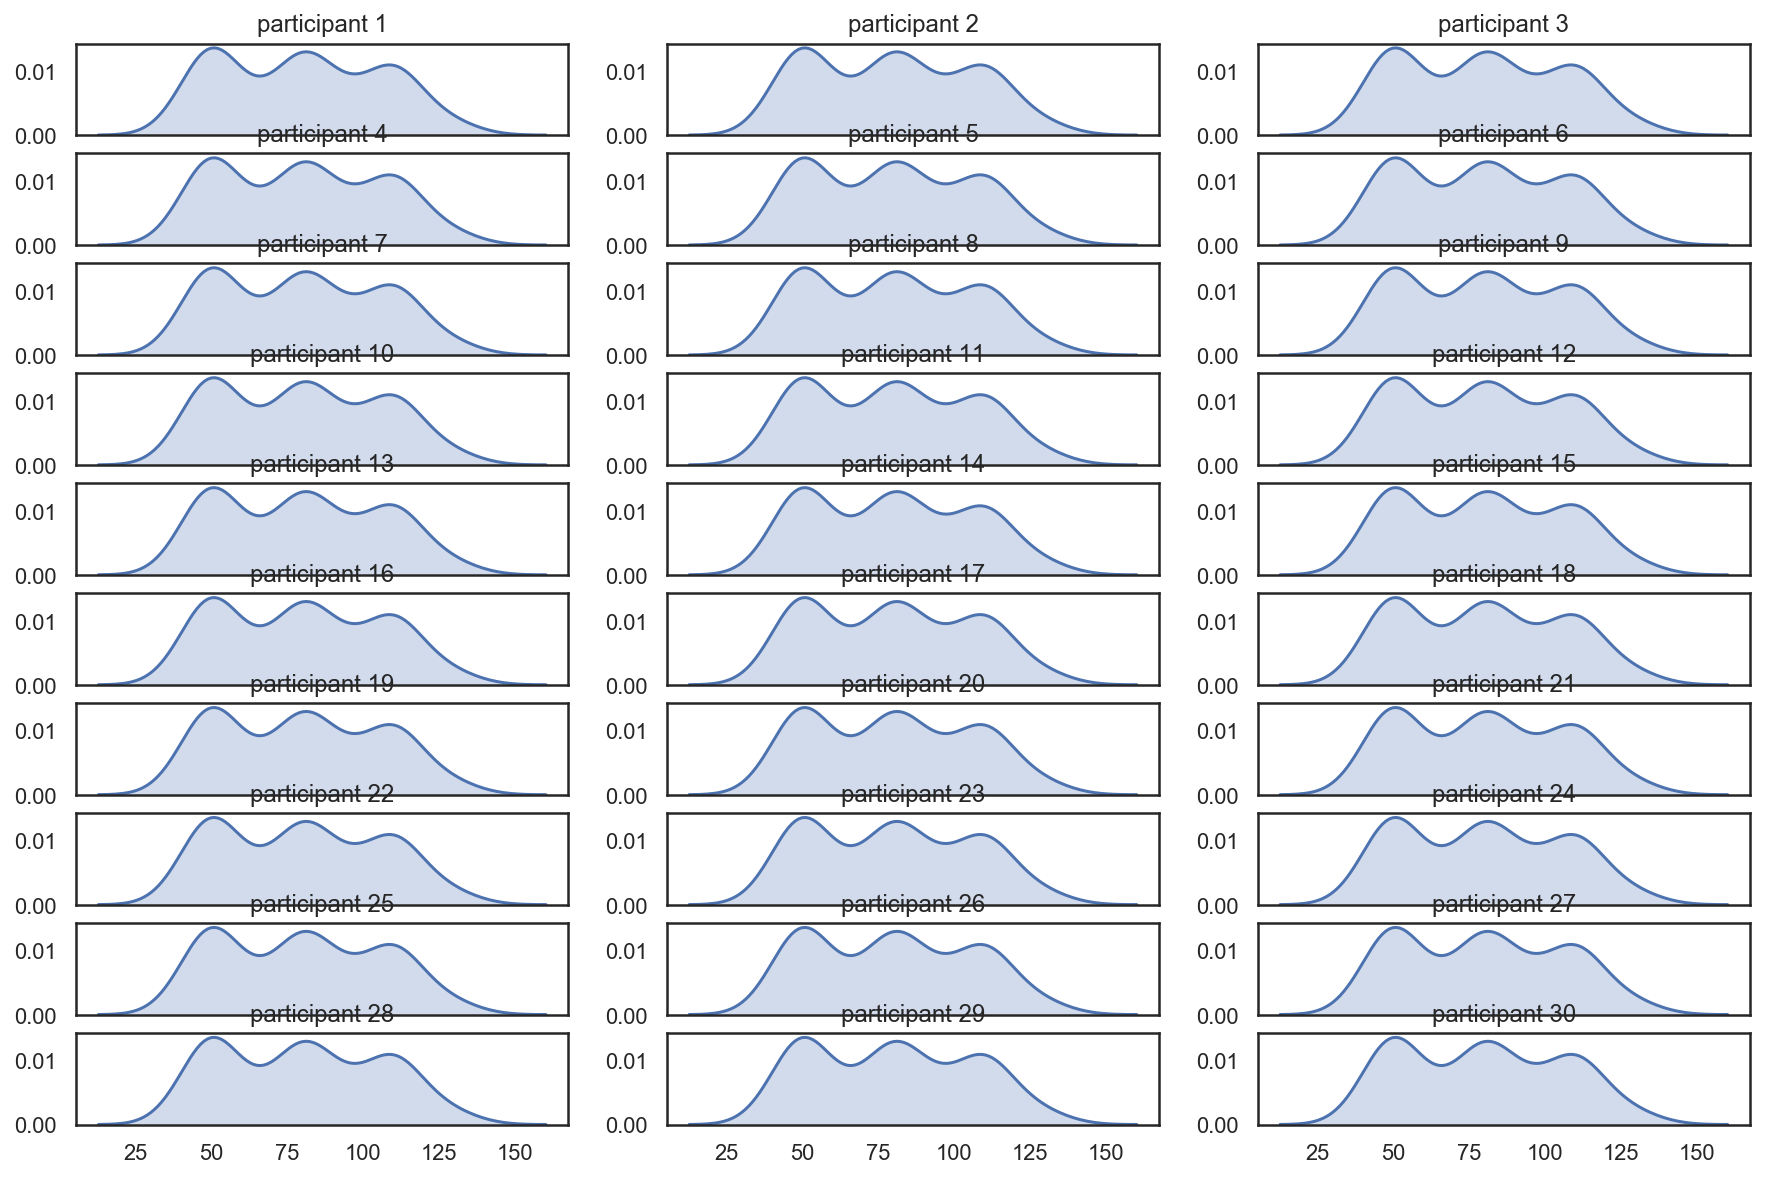

In [382]:
participant_densities(DataFrameSum1,'LValue') # Distribution of value of items

## Gaze Shift Frequencies

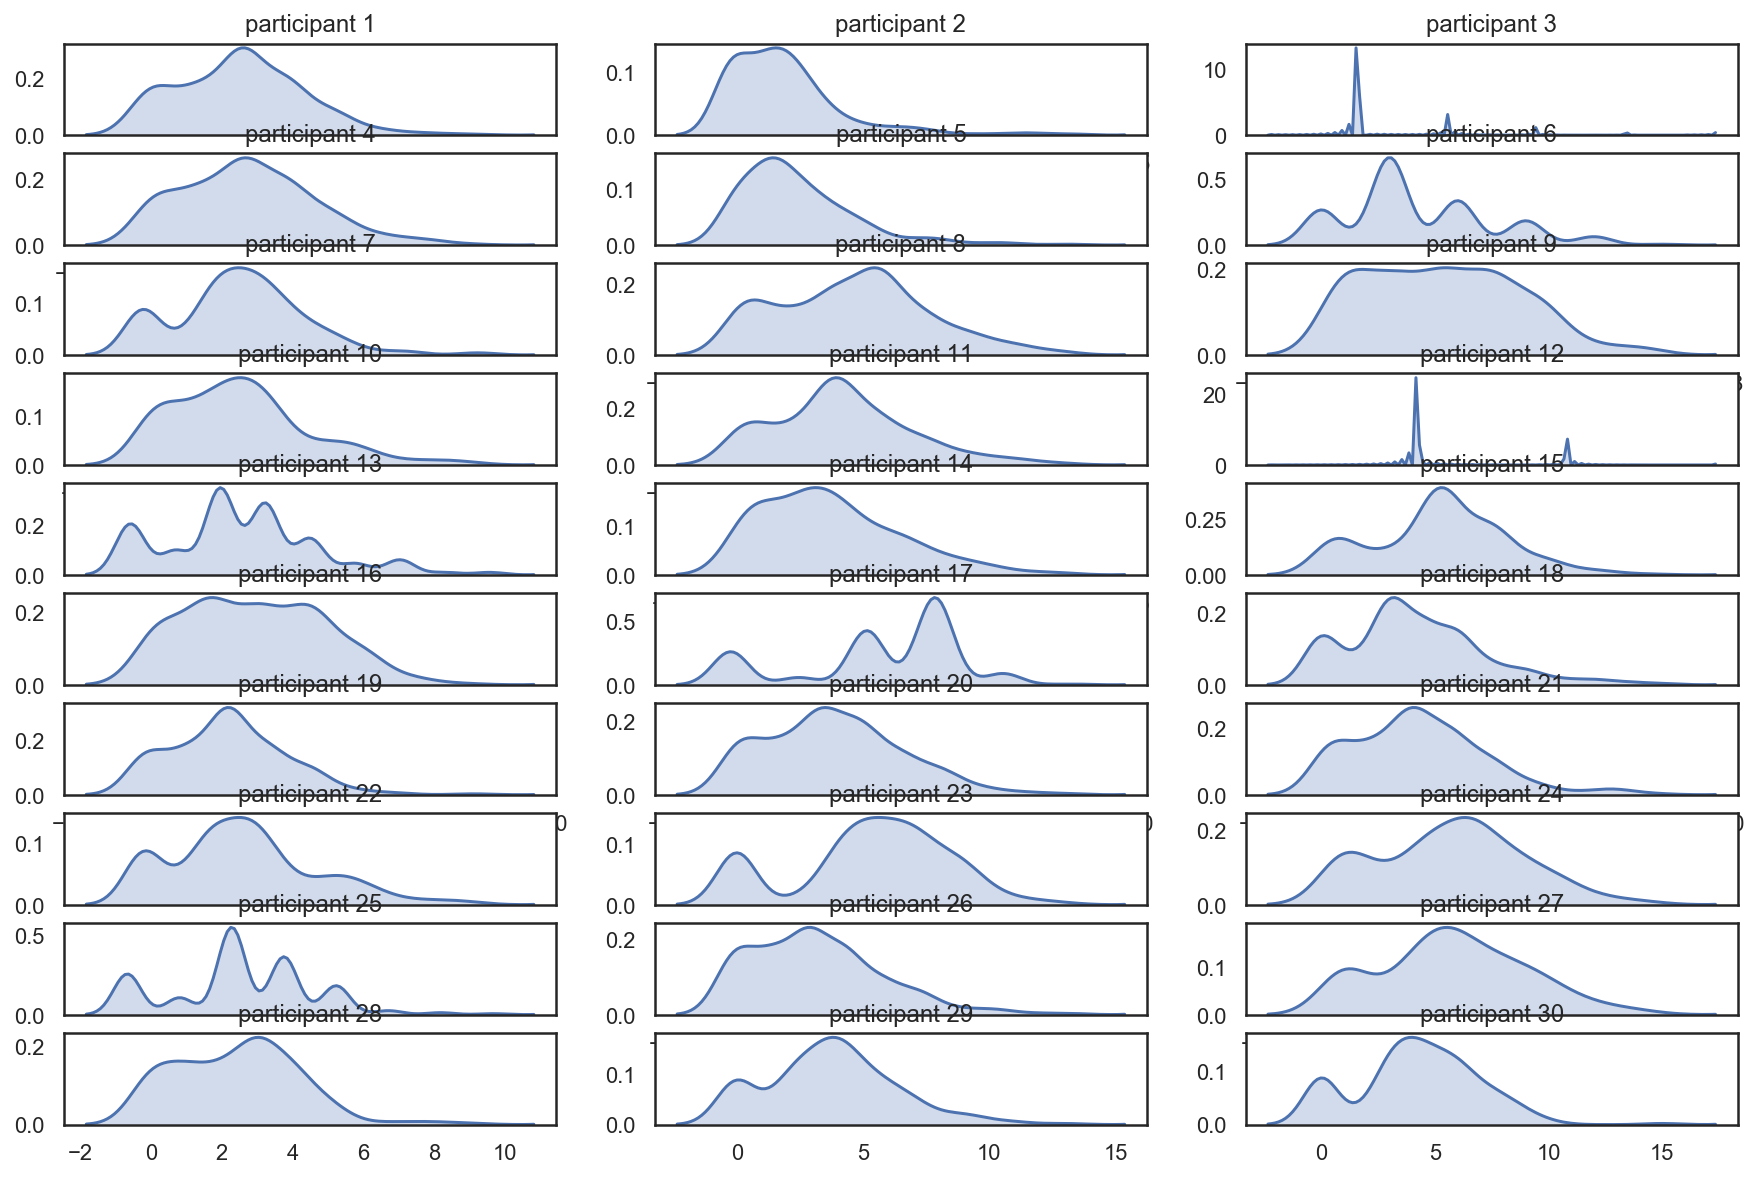

In [383]:
participant_densities(DataFrameSum1,'tGSF')

## 6 Calculate Z scores

In [384]:
# Calculate Z-values and other 
z_matrix=[]
z_matrix_aux=[]

for i in (DataFrameSum1['Part'].unique()):
    Choicedata = DataFrameSum1.loc[DataFrameSum1['Part'] == str(i)]
    # from v3 and on we define DV as  RIGHT - LEFT values of the items
    pX_DV = - pd.to_numeric(Choicedata["LValue"]) + pd.to_numeric(Choicedata["RValue"])
    pX_zDV = (pX_DV - np.mean(pX_DV))/np.std(pX_DV)
    pX_absDV = abs(- pd.to_numeric(Choicedata['LValue']) + pd.to_numeric(Choicedata['RValue']))
    pX_zAbsDV = (pX_absDV - np.mean(pX_absDV))/np.std(pX_absDV)
    pX_zConf = (pd.to_numeric(Choicedata['Conf']) - np.mean(pd.to_numeric(Choicedata['Conf'])))/np.std(pd.to_numeric(Choicedata['Conf']))
    pX_zChoiceRT = (pd.to_numeric(Choicedata['ChoiceRT'] )- np.mean(pd.to_numeric(Choicedata['ChoiceRT'])))/np.std(pd.to_numeric(Choicedata['ChoiceRT']))
        
    z_matrix_aux= np.column_stack((pX_DV,pX_zDV,pX_absDV,pX_zAbsDV,pX_zConf,pX_zChoiceRT))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])

In [385]:
# Add to aggregate table
Final_trial = np.column_stack((DDT_GSF_trial,z_matrix))
Final_head = np.insert(Final_trial,  0, np.array(('Part', 'TrialN', 'PairID', 'LValue', 'RValue', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'lIA_DT', 'rIA_DT', 'tGSF','lastFixat','DV','zDV','absDV','zAbsDV','zConf','zChoiceRT')), axis=0)
pd.DataFrame(Final_head)
data_exp1 = pd.DataFrame(Final_trial,columns = ['Part', 'TrialN', 'PairID', 'LValue', 'RValue', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond', 'tDDT', 'lIA_DT', 'rIA_DT', 'tGSF','lastFixat','DV','zDV','absDV','zAbsDV','zConf','zChoiceRT'])
data_exp1.head()

Part TrialN PairID LValue RValue ChosenITM            ChoiceRT Conf  \
0    1      1     49    110    131         0            4261.735   74   
1    1      2     13     47     50         1            3559.258   54   
2    1      3     16     50     44         1  3754.4640000000004   64   
3    1      4      7     57     50         0            2431.751   84   
4    1      5     18     42     50         0            2199.342   44   

               ConfRT BlockCond  tDDT lIA_DT rIA_DT tGSF lastFixat    DV  \
0  1584.9660000000001      LESS  -704   2114   1410    0         0  21.0   
1  1864.3870000000002      LESS     8   1332   1340    0         0   3.0   
2  3778.8070000000002      LESS    38   1272   1310    0         0  -6.0   
3            3064.179      LESS  -587   1261    674    0         0  -7.0   
4            2850.845      LESS  -749   1291    542    0         0   8.0   

                   zDV absDV                zAbsDV                zConf  \
0   1.9685577674164243  21.0     2.095290887308735  0.38883333852157215   
1  0.28122253820234633   3.0   -1.0476454436543674  -0.6400531140162148   
2  -0.5624450764046927   6.0   -0.5238227218271837  -0.1256098877473213   
3  -0.6561859224721414   7.0  -0.34921514788478913   0.9032765647904656   
4   0.7499267685395902   8.0  -0.17460757394239457  -1.1544963402851083   

              zChoiceRT  
0    1.2284490278498308  
1    0.6552951027993201  
2    0.8145644953821521  
3   -0.2646425785367606  
4  -0.45426605456097807

In [386]:
np.savetxt("DataPerceptFramingNotebook_v1.csv", Final_head, delimiter=",", fmt='%s')

### Add Extra Columns for Analysis

In [387]:
ValChosen = []
ValUnChosen = []
Tot_Val = []
Correct_val = []
correct = []

trial_count = 0

#for cycle for participant
#for k in range(0,len(file_array)):
    #BDMframe = [pd.read_csv(file_array[k], sep="\t")]
    #BDMdata = pd.concat(BDMframe)
    #for cycle for trials
data_exp1['Part'] = pd.to_numeric(data_exp1['Part'])
for k in range(len(percpart)):
    data_part = data_exp1.loc[(data_exp1['Part'] == k+1)]
    #print(k+1)
    trial_n = data_part['TrialN'].unique()
    #print(data_part)
    trial_count=(240*k)
    if k > 13: # account for missing trial
        trial_count -= 1
    for  j in range(len(trial_n)):
        #print(j)
        #Pick identity left item  
        Value_L = data_part.loc[trial_count,['LValue']].values[0]
        
        #Pick identity right item
        
        Value_R = data_part.loc[trial_count,['RValue']].values[0]
        
        ChosenITMtrial = data_part['ChosenITM'][trial_count]
        BlockCondtrial = data_part['BlockCond'][trial_count]

        if ChosenITMtrial == "1":  #Selected Item is Right
            
            ValUnChosenT  = Value_L
            ValChosenT  = Value_R
            
            if BlockCondtrial == "MORE" or BlockCondtrial == "NEXTLESS": # Block is like, correct chosen is higher value
                if Value_R >= Value_L:
                    correct = 1
                else: 
                    correct = 0 
            if BlockCondtrial == "LESS" or BlockCondtrial == "NEXTMORE" :# Block is dislike, correct chosen is lower value
                if Value_L >= Value_R:
                    correct = 1
                else: 
                    correct = 0  
                
        else: # Selected item is Left
            
            ValUnChosenT  = Value_R           
            ValChosenT = Value_L
            
            if BlockCondtrial == "LESS" or BlockCondtrial == "NEXTMORE": # Block is like, correct chosen is higher value
                if Value_L <= Value_R:
                    correct = 1
                else: 
                    correct = 0
            
            if BlockCondtrial == "MORE" or BlockCondtrial == "NEXTLESS":# Block is dislike, correct chosen is lower value
                if Value_R <= Value_L:
                    correct = 1
                else: 
                    correct = 0  
        
        
        ValTot = Value_L + Value_R
        
        #add to the rows with current trial measures
        
        Tot_Val.append(str(ValTot))    
        ValChosen.append(str(ValChosenT))
        ValUnChosen.append(str(ValUnChosenT))
        Correct_val.append(str(correct))
        
        if trial_count != 3129:
            trial_count = trial_count + 1

In [388]:
table_aux= np.column_stack((Tot_Val, ValChosen, ValUnChosen, Correct_val))

### Check they are the same length

In [389]:
print(len(table_aux))
print(len(data_exp1))

7199
7199


In [390]:
New_variables = pd.DataFrame(table_aux,columns=['TotVal','ValCh','ValUnCh','Correct'])

In [391]:
new_data = pd.concat([data_exp1, New_variables],axis =1)

# Generate Z-Scored versions of Variables

In [392]:
z_matrix=[]
z_matrix_aux=[]

for i in unique(new_data["Part"]):
    Choicedata = new_data.loc[new_data['Part'] == i]
    
    pX_totVal = pd.to_numeric(Choicedata['TotVal'])
    z_totVal = (pX_totVal - np.mean(pX_totVal))/np.std(pX_totVal)
    
    pX_ValChosen = pd.to_numeric(Choicedata['ValCh'])
    z_ValChosen = (pX_ValChosen - np.mean(pX_ValChosen))/np.std(pX_ValChosen)

    pX_ValUnChosen = pd.to_numeric(Choicedata['ValUnCh'])
    z_ValUnChosen = (pX_ValUnChosen - np.mean(pX_ValUnChosen))/np.std(pX_ValUnChosen)
    
    pX_tGSF = pd.to_numeric(Choicedata['tGSF'])
    z_tGSF = (pX_tGSF - np.mean(pX_tGSF))/np.std(pX_tGSF)
    
    pX_tDDT = pd.to_numeric(Choicedata['tDDT'])
    z_tDDT = (pX_tDDT - np.mean(pX_tDDT))/np.std(pX_tDDT)
    
    pX_ValR = pd.to_numeric(Choicedata['RValue'])
    zValR = (pX_ValR - np.mean(pX_ValR))/np.std(pX_ValR)
    
    
    pX_ValL = pd.to_numeric(Choicedata['LValue'])
    zValL = (pX_ValL - np.mean(pX_ValL))/np.std(pX_ValL)
    

    absDDT = abs(z_tDDT)

    z_matrix_aux= np.column_stack((z_totVal,z_ValChosen,z_ValUnChosen, z_tGSF, z_tDDT, absDDT, zValR, zValL))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])

In [393]:
Zmatrix_part = pd.DataFrame(z_matrix,columns=['zTotVal','zValCh','zValUnCh', 'zGSF', 'zDDT', 'absDDT', 'zValR', 'zValL'])

In [394]:
data_exp1 = pd.concat([new_data, Zmatrix_part],axis =1)

#data_exp1

In [395]:
data_exp1 = data_exp1.apply(pd.to_numeric, errors='ignore')
expdata_frame = data_exp1.loc[:,['Part', 'TrialN','ChoiceRT', 'ChosenITM','LValue','RValue','BlockCond'] ]

expdata_frame['ChosenITM'] = expdata_frame['ChosenITM'].apply(lambda x:1 if x else -1)
expdata_frame['TrialN'] = expdata_frame['TrialN'].apply(lambda x: x-1)


In [396]:
expdata_frame.columns = ['parcode', 'trial', 'rt', 'choice', 'item_left','item_right','BlockCond']

In [397]:
pd.DataFrame.head(expdata_frame)

parcode  trial        rt  choice  item_left  item_right BlockCond
0        1      0  4261.735      -1        110         131      LESS
1        1      1  3559.258       1         47          50      LESS
2        1      2  3754.464       1         50          44      LESS
3        1      3  2431.751      -1         57          50      LESS
4        1      4  2199.342      -1         42          50      LESS

In [398]:
figsize(15, 15)
#Transform to numeric values in the dataframe
data_exp1 = data_exp1.apply(pd.to_numeric, errors='ignore')
#data_exp1.head()
#Show the list of data columns
list(data_exp1)


['Part',
 'TrialN',
 'PairID',
 'LValue',
 'RValue',
 'ChosenITM',
 'ChoiceRT',
 'Conf',
 'ConfRT',
 'BlockCond',
 'tDDT',
 'lIA_DT',
 'rIA_DT',
 'tGSF',
 'lastFixat',
 'DV',
 'zDV',
 'absDV',
 'zAbsDV',
 'zConf',
 'zChoiceRT',
 'TotVal',
 'ValCh',
 'ValUnCh',
 'Correct',
 'zTotVal',
 'zValCh',
 'zValUnCh',
 'zGSF',
 'zDDT',
 'absDDT',
 'zValR',
 'zValL']

In [399]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

# Plot Correlations

Pearson's r = 0.093 p =  0.0


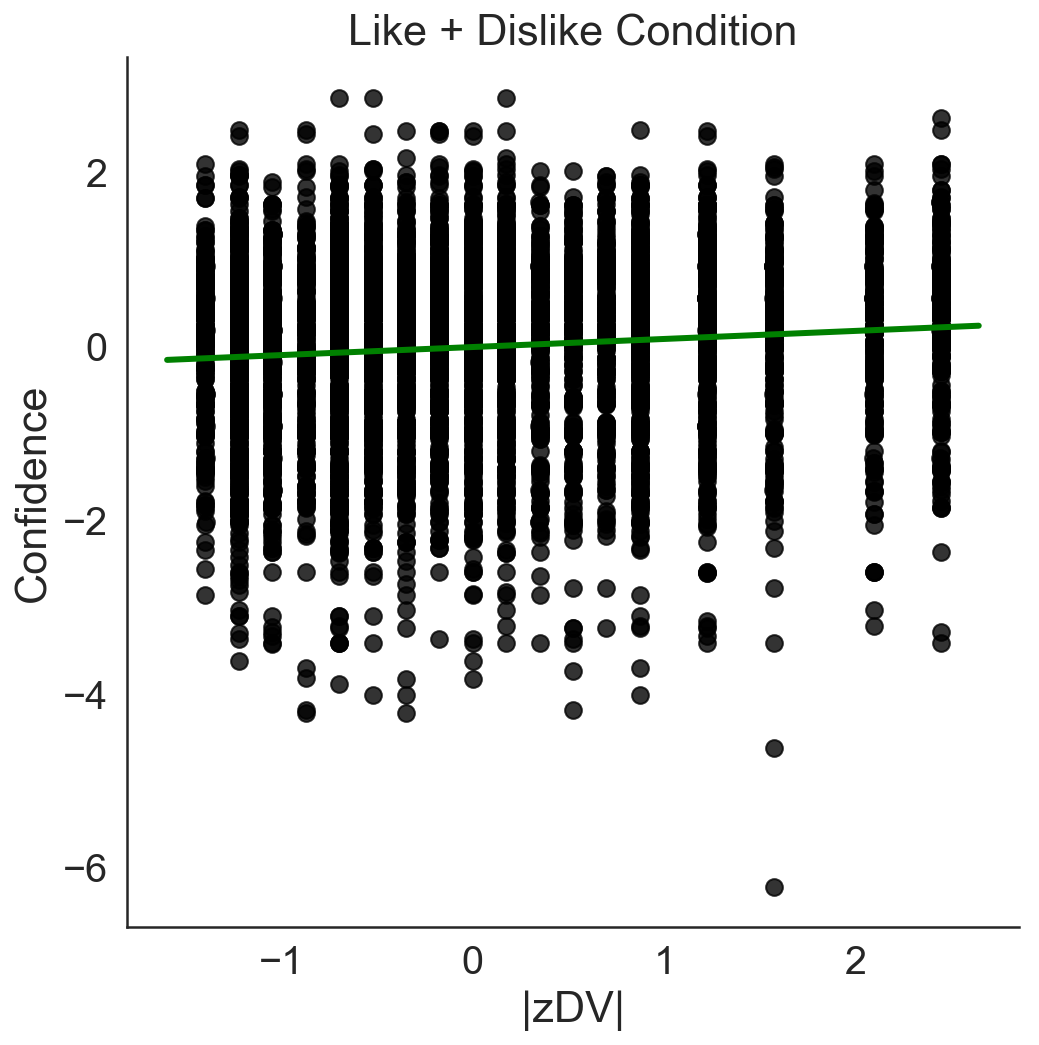

In [400]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=pd.to_numeric(data_exp1[x_variable]).values
y=pd.to_numeric(data_exp1[y_variable]).values
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Green', lw=3)
sns.despine()
ax.set_title('Like + Dislike Condition')



results = pearsonr(x, y)
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

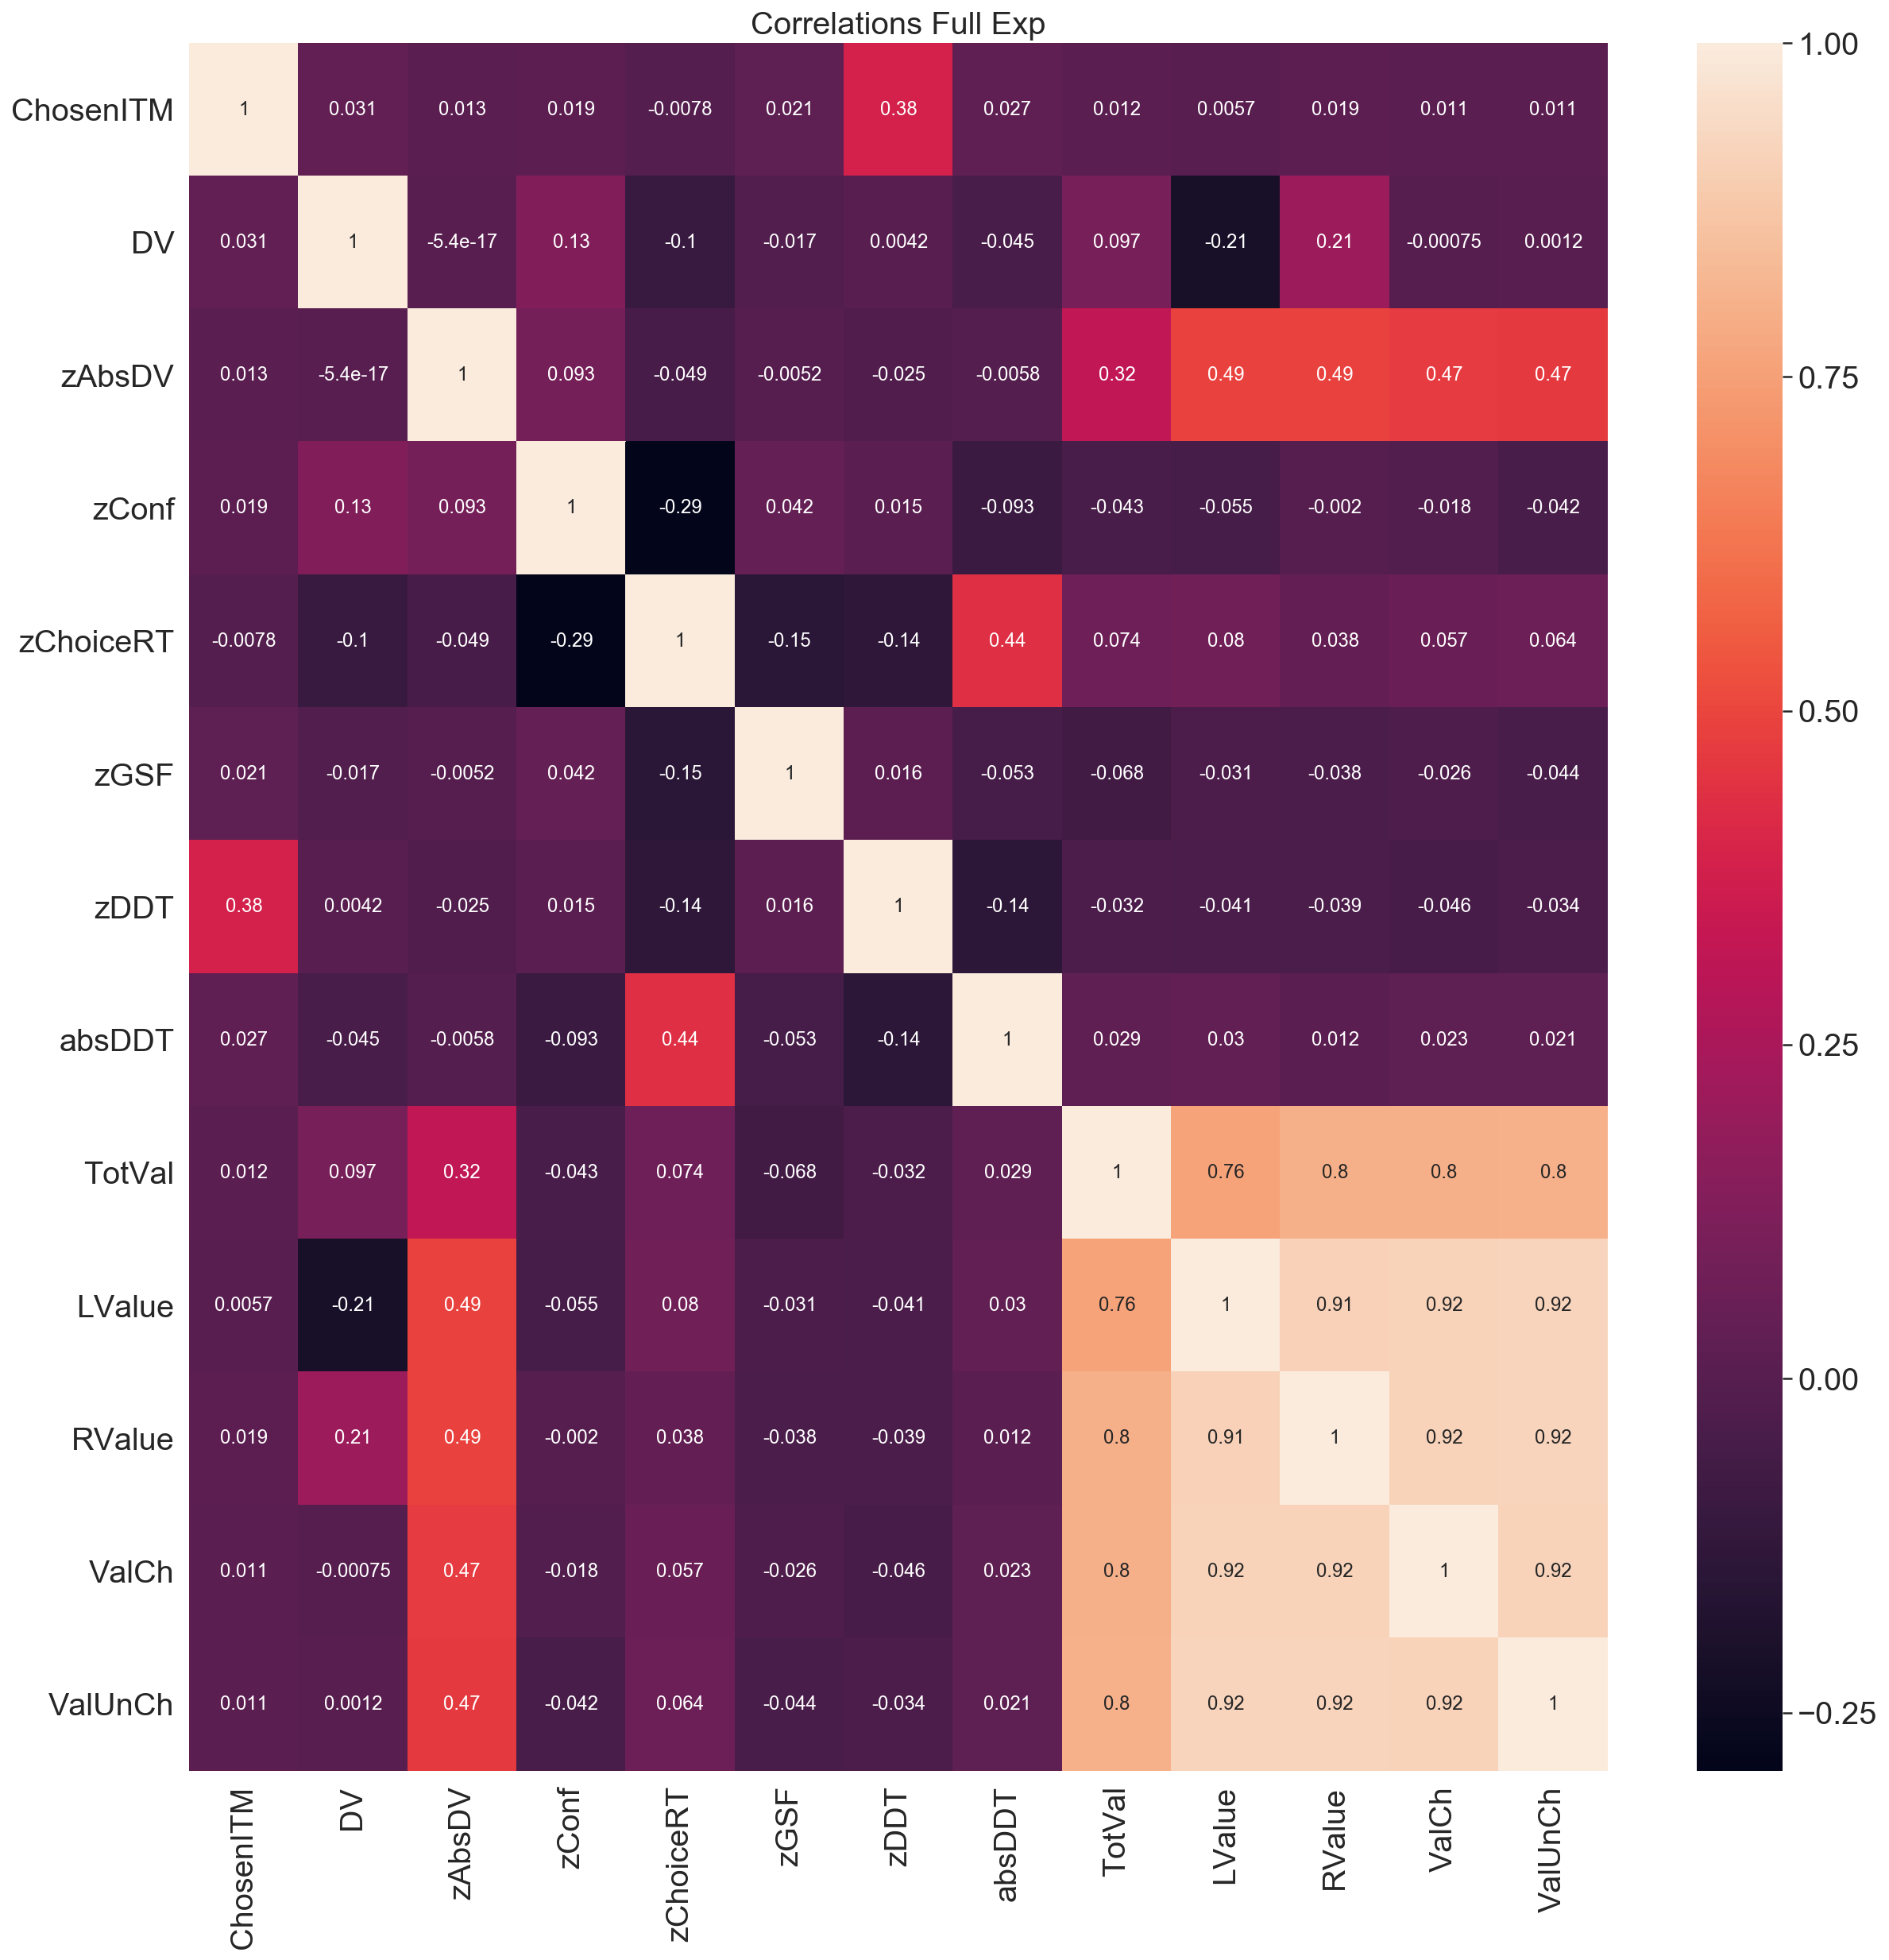

In [401]:
dataColsSelected = data_exp1.loc[:,  ['ChosenITM','DV','zAbsDV','zConf','zChoiceRT', 'zGSF', 'zDDT', 'absDDT', 'TotVal', 'LValue','RValue', 'ValCh', 'ValUnCh']]
dataColsSelected
data_corr = dataColsSelected.corr(method='pearson')
data_corr
# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(data_corr, 
       xticklabels=data_corr.columns,
       yticklabels=data_corr.columns, annot=True, annot_kws={"size": 12})

ax.set_title('Correlations Full Exp',fontsize=20)
#sns.set(font_scale=0.8)
savefig('CorrFull.png')

In [402]:
data_expM= data_exp1.loc[(data_exp1['BlockCond'] == 'MORE') | (data_exp1['BlockCond'] == 'NEXTLESS')] # 1 = Like, 2 = Dislike
data_expF= data_exp1.loc[(data_exp1['BlockCond'] == 'LESS') | (data_exp1['BlockCond'] == 'NEXTMORE')] # 1 = Like, 2 = Dislike

In [403]:
x_variable = 'zAbsDV'
x_varlabel = '|zDV|'
y_variable = 'zConf'
y_varlabel =  'Confidence'

Pearson's r = 0.139 p =  0.0


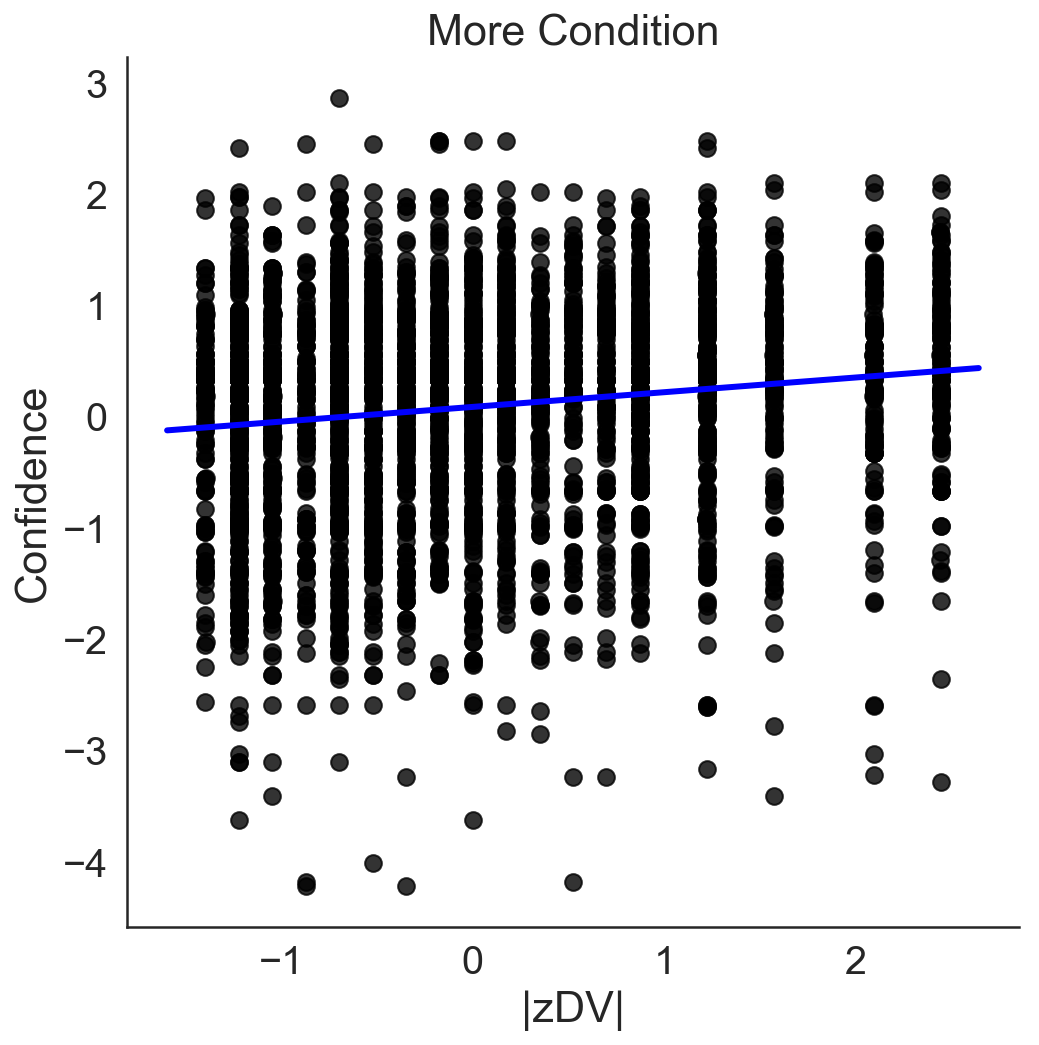

In [404]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_expM, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expM[x_variable]
y=data_expM[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Blue', lw=3)
sns.despine()
ax.set_title('More Condition')



results = pearsonr(data_expM[x_variable], data_expM[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))


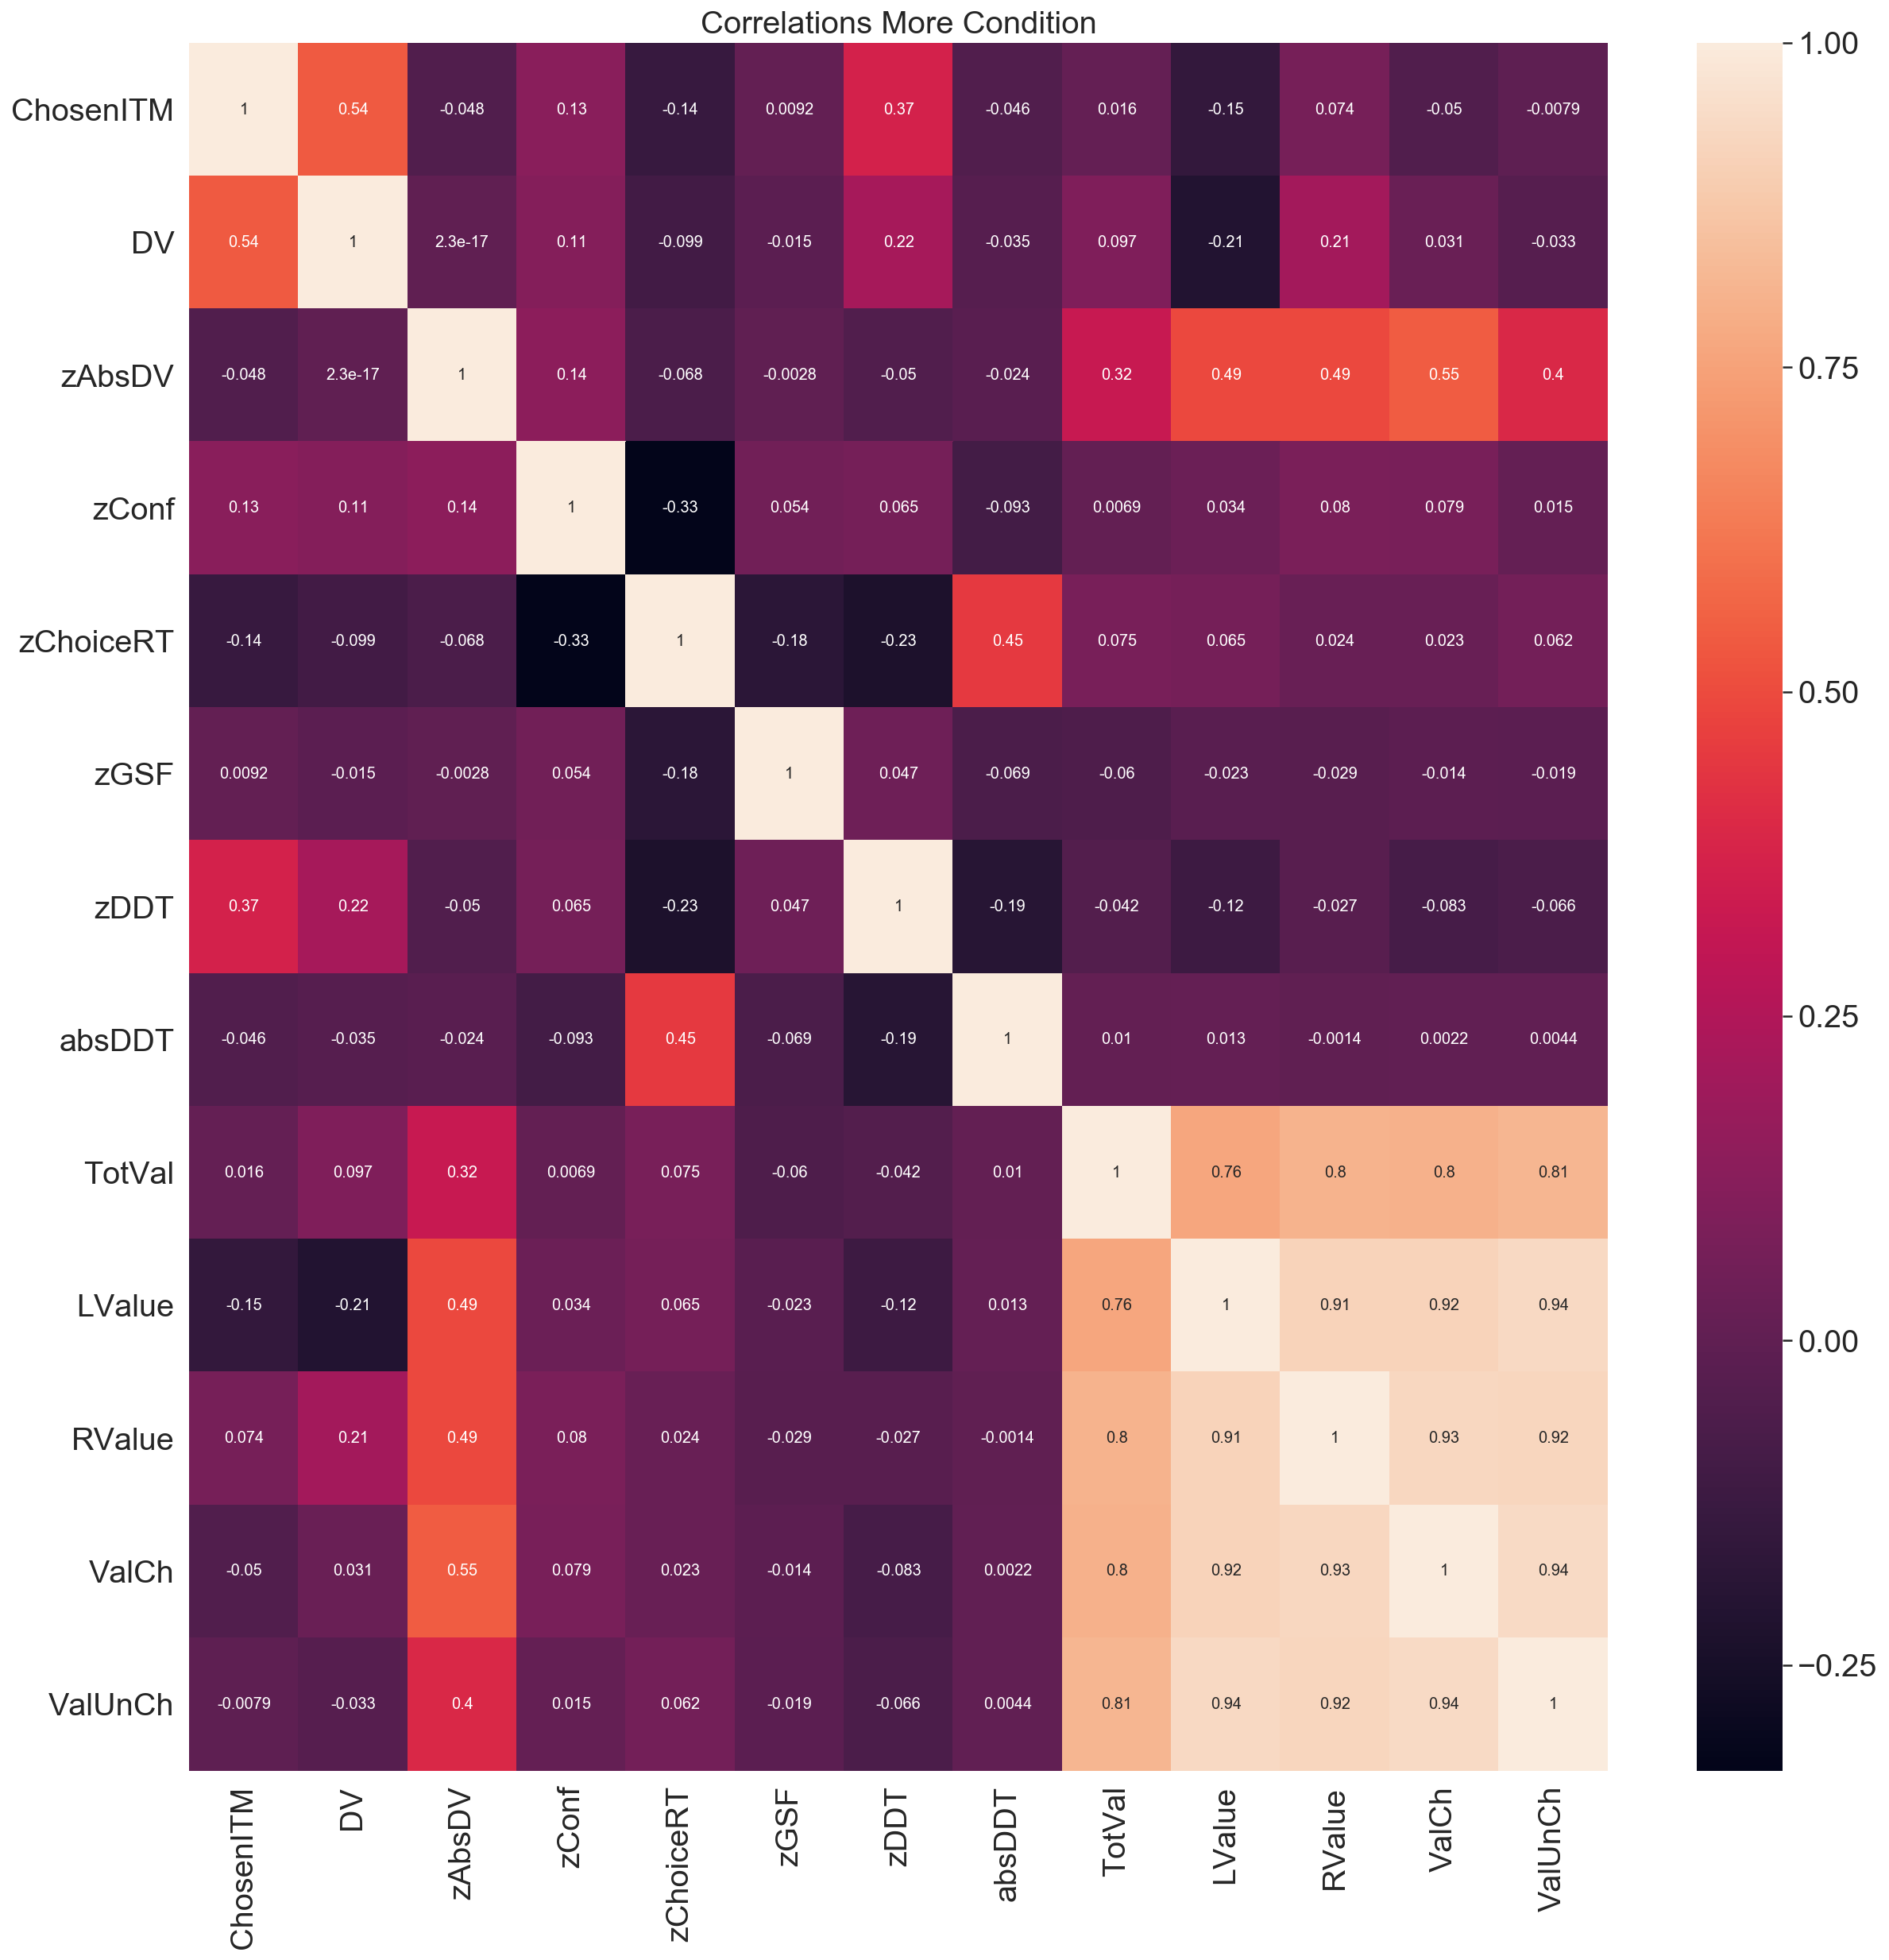

In [405]:
dataColsSelected = data_expM.loc[:, ['ChosenITM','DV','zAbsDV','zConf','zChoiceRT', 'zGSF', 
                                     'zDDT','absDDT', 'TotVal', 'LValue','RValue','ValCh', 'ValUnCh']]
dataColsSelected
data_corr = dataColsSelected.corr(method='pearson')
data_corr
# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(data_corr, 
       xticklabels=data_corr.columns,
       yticklabels=data_corr.columns, annot=True, annot_kws={"size": 10})

ax.set_title('Correlations More Condition',fontsize=20)

savefig('CorrMore.png')

Text(0.5,1,'Fewer Condition')

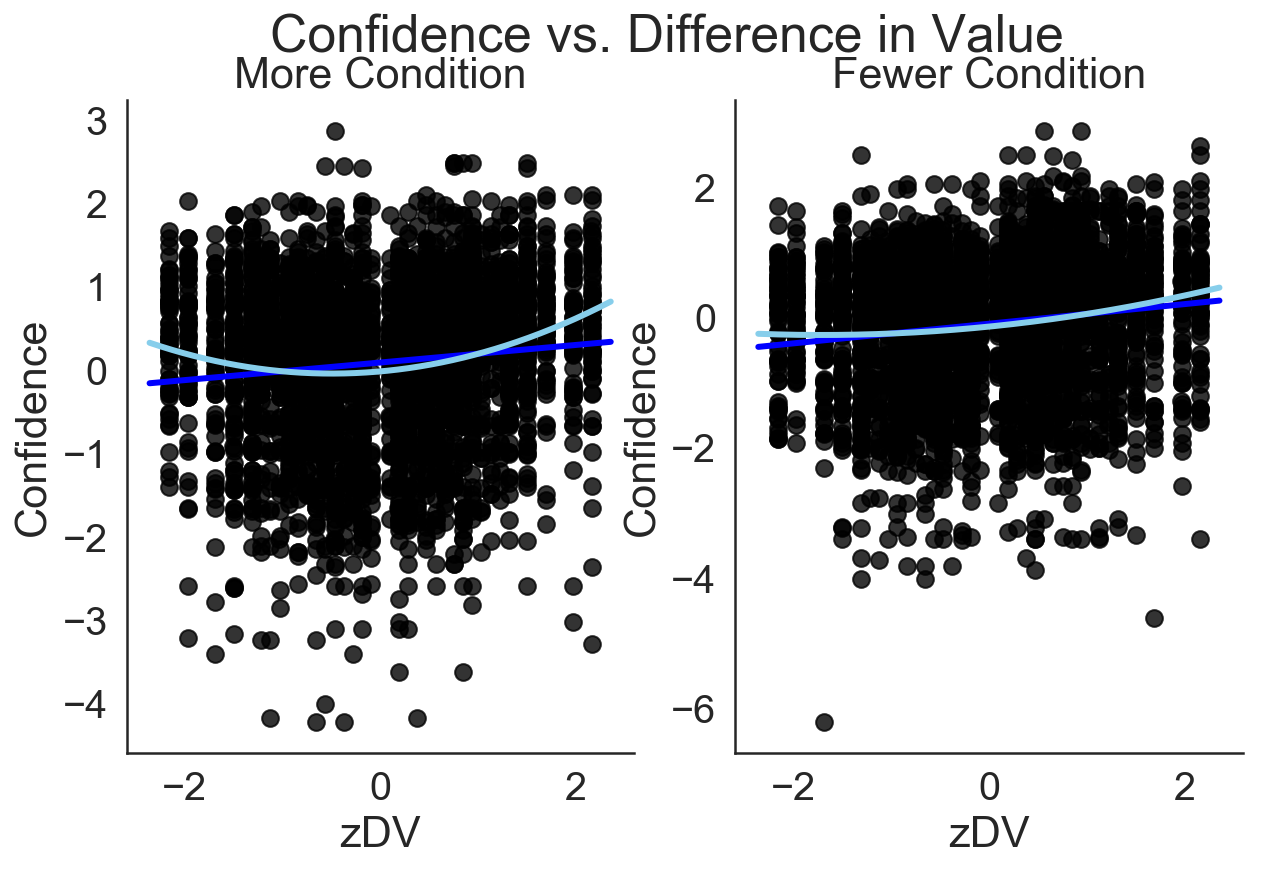

In [406]:
f = plt.figure(figsize=(10,6))
sns.set(style='white', font_scale=1.8)
plt.suptitle('Confidence vs. Difference in Value')

plt.subplot(121)

x_variable = 'zDV'
x_varlabel =  'zDV'
y_variable = 'zConf'
y_varlabel =  'Confidence'

ax = sns.regplot(data=data_expM, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expM[x_variable]
y=data_expM[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Blue', lw=3)

fit = np.polyfit(x, y, deg=2)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='skyblue', lw=3)

sns.despine()
ax.set_title('More Condition')

plt.subplot(122)

x_variable = 'zDV'
x_varlabel =  'zDV'
y_variable = 'zConf'
y_varlabel =  'Confidence'

ax = sns.regplot(data=data_expF, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expF[x_variable]
y=data_expF[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Blue', lw=3)

fit = np.polyfit(x, y, deg=2)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='skyblue', lw=3)

sns.despine()
ax.set_title('Fewer Condition')


Pearson's r = 0.146 p =  0.0


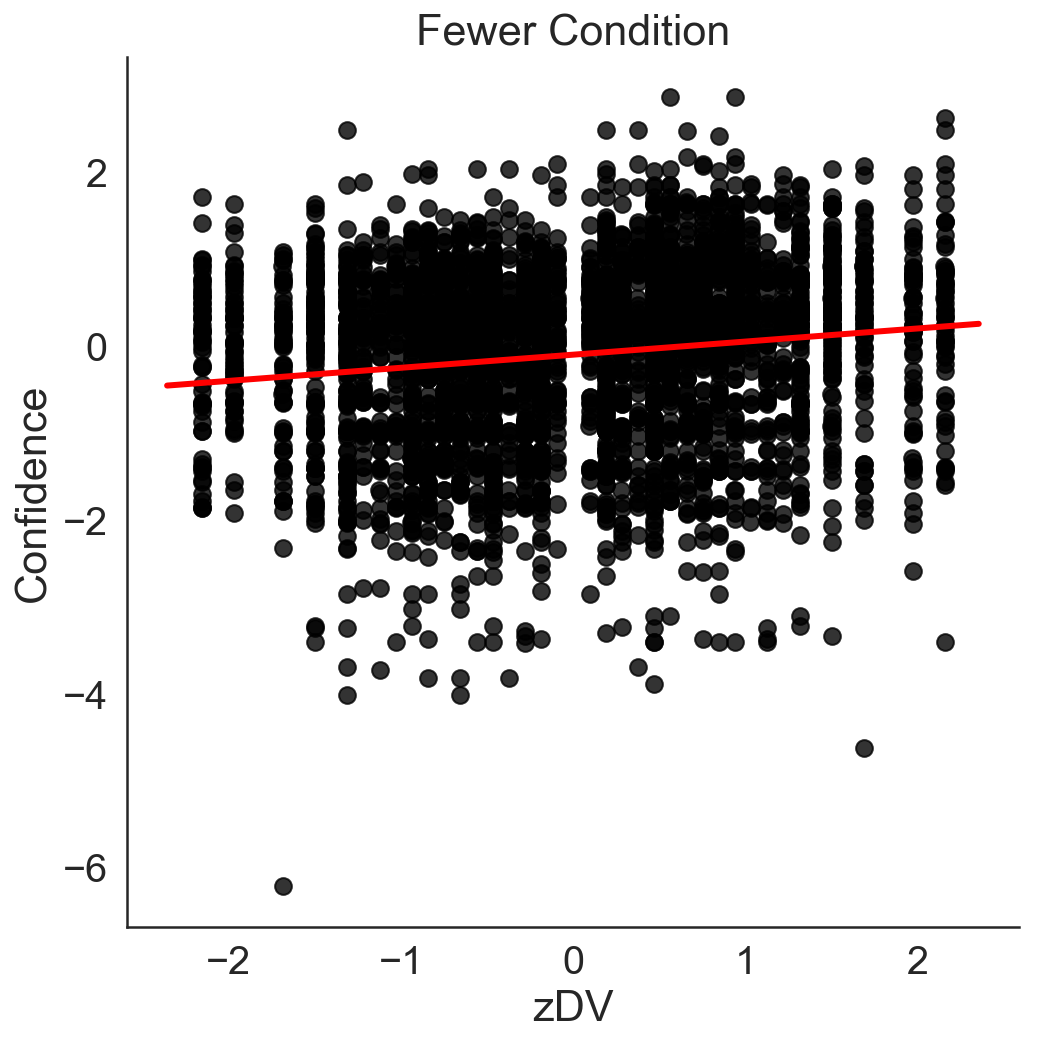

In [407]:
f = plt.figure(figsize=(8, 8))
sns.set(style='white', font_scale=1.8)
ax = sns.regplot(data=data_expF, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
#sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
#exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
#exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
#plt.legend(handles=[exp1, exp2], loc=3)
x=data_expF[x_variable]
y=data_expF[y_variable]
fit = np.polyfit(x, y, deg=1)
future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
fit_fn = np.poly1d(fit)
future_fit = np.polyval(fit_fn, future)
ax.plot(future, future_fit, color='Red', lw=3)
ax.set_title('Fewer Condition')
sns.despine()

results = pearsonr(data_expF[x_variable], data_expF[y_variable])
print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))

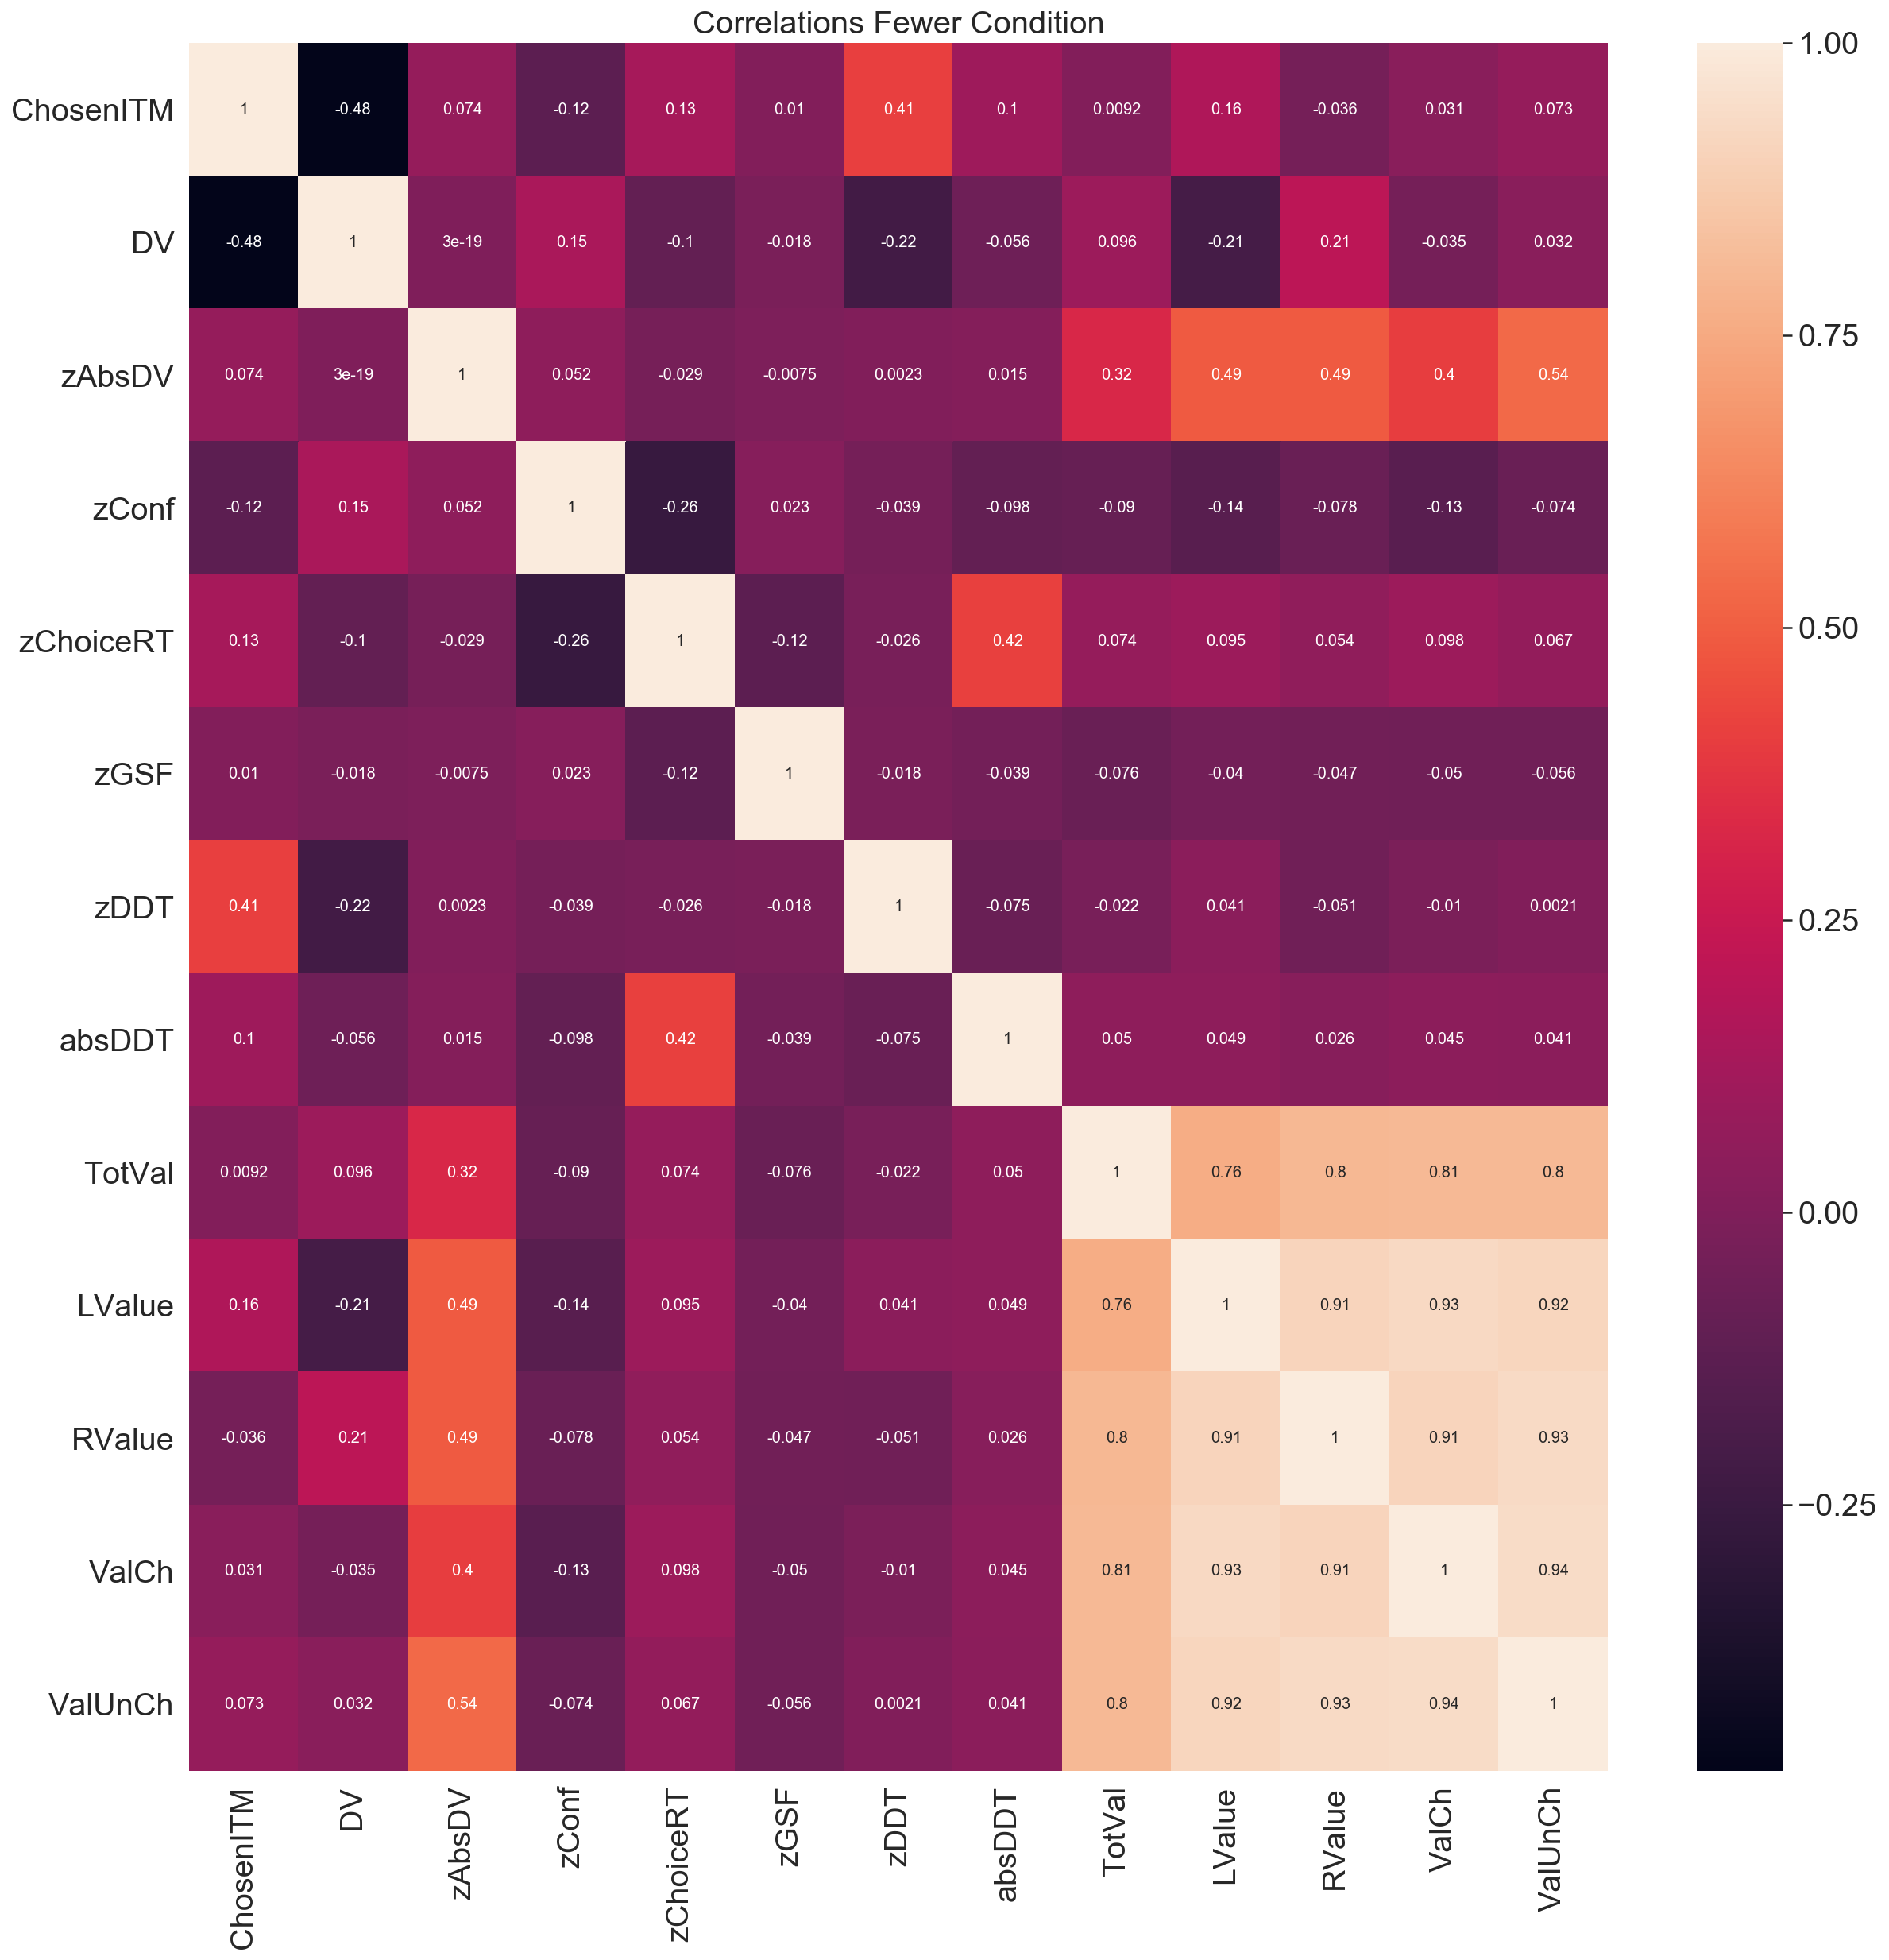

In [408]:
dataColsSelected = data_expF.loc[:, ['ChosenITM','DV','zAbsDV','zConf','zChoiceRT', 'zGSF', 
                                     'zDDT','absDDT', 'TotVal', 'LValue','RValue','ValCh', 'ValUnCh']]
dataColsSelected
data_corr = dataColsSelected.corr(method='pearson')
data_corr
# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(data_corr, 
       xticklabels=data_corr.columns,
       yticklabels=data_corr.columns, annot=True, annot_kws={"size": 10})

ax.set_title('Correlations Fewer Condition',fontsize=20)

savefig('Corrfew.png')

In [409]:
for i in range(len(new_data)): #data_expM= data_exp1.loc[(data_exp1['BlockCond'] == 'MORE') | (data_exp1['BlockCond'] == 'NEXTLESS')] # 1 = Like, 2 = Dislike
    if new_data.loc[i, ['BlockCond']].values[0] == 'NEXTLESS' : #data_expF= data_exp1.loc[(data_exp1['BlockCond'] == 'LESS') | (data_exp1['BlockCond'] == 'NEXTMORE')] # 1 = Like, 2 = Dislike
        new_data.loc[i, ['BlockCond']] = 'MORE'
        #print(new_data.loc[i, ['BlockCond']])
        #willsacunt +=1
    if new_data.loc[i, ['BlockCond']].values[0] == 'NEXTMORE':
        new_data.loc[i, ['BlockCond']] = 'LESS'
        #print(new_data.loc[i, ['BlockCond']])
        #willsacunt+= 1

# Split the data by high/low Confidence, GSF and DDT

In [410]:
#
Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit']
Splits_variables = ['Conf', 'tGSF','tDDT']
partic = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
median_matrix=[]
median_matrix_aux=[]
median_matrix_aux_cond=[]
Split_cols = []

for h in range(len(Splits_variables)):
    median_matrix=[]
    for i in partic: #unique(new_data["Part"]):
        #print(unique(new_data["Part"]))
        #print(median_matrix_aux)
        median_matrix_aux=[]
        #print(1)
        for j in unique(new_data["BlockCond"]):
            #median_matrix_aux_cond=[]

            #Extract data by participant and BlockCond (1: Like, 2: Dislike)
            Splitdata = new_data.loc[new_data['Part'] == i]
            Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
            
            # Select the column to split
            Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]],]
            SplitSort = Splitdata.values
            
            SplitSort[:,0] = pd.to_numeric(SplitSort[:,0]) # so they sort numerically not as a string
            SplitSort[:,1] = pd.to_numeric(SplitSort[:,1])
            #print(SplitSort)
            # Sort for confidence column
            SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
            #print(SplitSort)
            lenPart = len(Splitdata)
            #print(lenPart)
            # Generate column with median order
            median_low = [0] * int (lenPart/2)
            #print(len(median_low))
            if len(SplitSort) != 2*len(median_low):
                median_high=  [1] * int(60)
            else: median_high = [1] * int (lenPart/2)
                
            #print(len(median_high))
            median_split_order = median_low + median_high
            #Attach split median order column (1 and 0)
            median_aux= np.column_stack((SplitSort,median_split_order))
            #Sort back to trial number
            #print(len(median_aux))
            #print(median_aux)
            SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
            #print(SplitSorted)
            #for kk in range(len(SplitSorted)): 
            #if len(median_matrix_aux) == 0:
                #median_matrix_aux = SplitSorted
                #print('hi')
            #else:
                #median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted])
                #print(median_matrix_aux)
                #print('hey')
                #median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
                #median_matrix.append(median_matrix_aux)
                #median_matrix_aux
            #print(median_matrix_aux)
            
            for kk in range(len(SplitSorted)): 
                if len(median_matrix_aux) == 0:
                    median_matrix_aux = SplitSorted[0]
                else:
                    median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
            median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
            #print(median_matrix_aux)
            
                    
        # sort after adding both conditions    
        
        #print(median_matrix_aux)
        #print(median_matrix_aux)
        #Extract only the column with the median split information
        median_matrix_aux = median_matrix_aux[:,2]
        #print(median_matrix_aux)
        #append to median matrix for the participants
        for k in range(len(median_matrix_aux)):    
            median_matrix.append(median_matrix_aux [k])
    
    median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
    #print(len (median_matrix))
    #add new column (new split variable columns) to the split matrix
    if  h == 0:
        Split_cols = median_matrix
    else:
        Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)

In [411]:
new_data['LValue'] = pd.to_numeric(new_data['LValue'])
new_data['RValue'] = pd.to_numeric(new_data['RValue'])
data_exp1['zValR'] = pd.to_numeric(data_exp1['zValR'])
data_exp1['zValL'] = pd.to_numeric(data_exp1['zValL'])

base_code = []
High = []
Low = []
for i in range(len(new_data)):
    if data_exp1.loc[i,['zValL']][0] > data_exp1.loc[i,['zValR']][0]:
        High.append(data_exp1.loc[i,['zValL']][0])
        Low.append(data_exp1.loc[i,['zValR']][0])
    else: 
        High.append(data_exp1.loc[i,['zValR']][0])
        Low.append(data_exp1.loc[i,['zValL']][0])
    if new_data.loc[i,['LValue']][0] == 50 or new_data.loc[i,['RValue']][0] == 50:
        base_code.append(0)
    elif new_data.loc[i,['LValue']][0] == 80 or new_data.loc[i,['RValue']][0] == 80:
        base_code.append(1)
    elif new_data.loc[i,['LValue']][0] == 110 or new_data.loc[i,['RValue']][0] == 110:
        base_code.append(2)
    else:
        print('nobase')



In [412]:
High = pd.DataFrame(High, columns=['High'])
Low = pd.DataFrame(Low, columns=['Low'])
base_code = pd.DataFrame(base_code, columns=['BaseCode'])

base_code1 = pd.concat([base_code, High, Low], axis = 1)

In [413]:
'''column_convert = ['zConf', 'zDV','ChosenITM']
for j in column_convert:
    for i in range(len(data_exp1[j])):
        data_exp1[j][i] = float(data_exp1[j][i])'''
    

"column_convert = ['zConf', 'zDV','ChosenITM']\nfor j in column_convert:\n    for i in range(len(data_exp1[j])):\n        data_exp1[j][i] = float(data_exp1[j][i])"

In [414]:
#Join new familiarity and split datasets with the old trial information
data_exp1 = pd.concat([new_data, Zmatrix_part, Split_cols, base_code1],axis =1)

pd.DataFrame.head(data_exp1)

Part TrialN PairID  LValue  RValue ChosenITM            ChoiceRT Conf  \
0     1      1     49     110     131         0            4261.735   74   
1     1      2     13      47      50         1            3559.258   54   
2     1      3     16      50      44         1  3754.4640000000004   64   
3     1      4      7      57      50         0            2431.751   84   
4     1      5     18      42      50         0            2199.342   44   

               ConfRT BlockCond  tDDT lIA_DT rIA_DT tGSF lastFixat    DV  \
0  1584.9660000000001      LESS  -704   2114   1410    0         0  21.0   
1  1864.3870000000002      LESS     8   1332   1340    0         0   3.0   
2  3778.8070000000002      LESS    38   1272   1310    0         0  -6.0   
3            3064.179      LESS  -587   1261    674    0         0  -7.0   
4            2850.845      LESS  -749   1291    542    0         0   8.0   

                   zDV absDV                zAbsDV                zConf  \
0   1.9685577674164243  21.0     2.095290887308735  0.38883333852157215   
1  0.28122253820234633   3.0   -1.0476454436543674  -0.6400531140162148   
2  -0.5624450764046927   6.0   -0.5238227218271837  -0.1256098877473213   
3  -0.6561859224721414   7.0  -0.34921514788478913   0.9032765647904656   
4   0.7499267685395902   8.0  -0.17460757394239457  -1.1544963402851083   

              zChoiceRT  TotVal ValCh ValUnCh Correct   zTotVal    zValCh  \
0    1.2284490278498308  110131   110     131       1  1.577420  1.179965   
1    0.6552951027993201    4750    50      47       0 -0.668902 -1.189178   
2    0.8145644953821521    5044    44      50       1 -0.662635 -1.426093   
3   -0.2646425785367606    5750    57      50       0 -0.647586 -0.912778   
4  -0.45426605456097807    4250    42      50       1 -0.679560 -1.505064   

   zValUnCh      zGSF      zDDT    absDDT     zValR     zValL  ConfSplit  \
0  1.971302 -1.430827 -0.423132  0.423132  1.989851  1.170501          1   
1 -1.268138 -1.430827  0.913173  0.913173 -1.170501 -1.287551          0   
2 -1.152443 -1.430827  0.969478  0.969478 -1.404601 -1.170501          0   
3 -1.152443 -1.430827 -0.203543  0.203543 -1.170501 -0.897384          1   
4 -1.152443 -1.430827 -0.507590  0.507590 -1.170501 -1.482634          0   

   GSFMedSplit  DDTMedSplit  BaseCode      High       Low  
0            0            0         2  1.989851  1.170501  
1            0            1         0 -1.170501 -1.287551  
2            0            1         0 -1.170501 -1.404601  
3            0            0         0 -0.897384 -1.170501  
4            0            0         0 -1.170501 -1.482634

In [415]:
def parsplit(DF, input, quantiles):
    qvalues = pd.qcut(DF[input], quantiles, labels = range(1, quantiles+1))
    return qvalues

def logisticplot_all (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Low measure coef',clf.coef_)
    
    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()
    print ('High measure coef',clf.coef_)



    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5)
    

    #Plotting the binned data
    data['DVBin2'] = data.groupby(parvar).apply(parsplit, input=xaxis, quantiles=4).values
    
    # determine the x coordinates
    x_cords= data.groupby('DVBin2')[xaxis].mean()
    
    # determine low y coordinates
    y_cords_low = data.loc[(data[moderator]==0), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine low y standard errors
    test = pd.DataFrame(data.loc[(data[moderator]==0), :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_low_error = test.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    
    # determine high y coordinates
    y_cords_high = data.loc[(data[moderator]==1), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine high y standard errors
    test2 = pd.DataFrame(data.loc[data[moderator]==1, :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_high_error = test2.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    # plot the low points
    plt.scatter(x_cords, y_cords_low, c=modlowcol, marker='D', s=60, zorder=1)
    # plot low error bars
    plt.errorbar(x_cords, y_cords_low, yerr=y_low_error, fmt='o', zorder=3, c=modlowcol)
    
    # plot the high points
    plt.scatter(x_cords, y_cords_high, c=modhighcol, marker='o', s=60, zorder=2)
    # plot high error bars
    plt.errorbar(x_cords, y_cords_high, yerr=y_high_error, fmt='o', zorder=4, c=modhighcol)
    
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=2, prop={'size':20})
    sns.despine()

In [416]:
def logisticplot_simpl (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data_exp1.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis], data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Low measure coef',clf.coef_)
    
    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()
    print ('High measure coef',clf.coef_)



    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=2, prop={'size':20})
    sns.despine()

C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Low measure coef [[1.06246629]]
High measure coef [[2.02232949]]


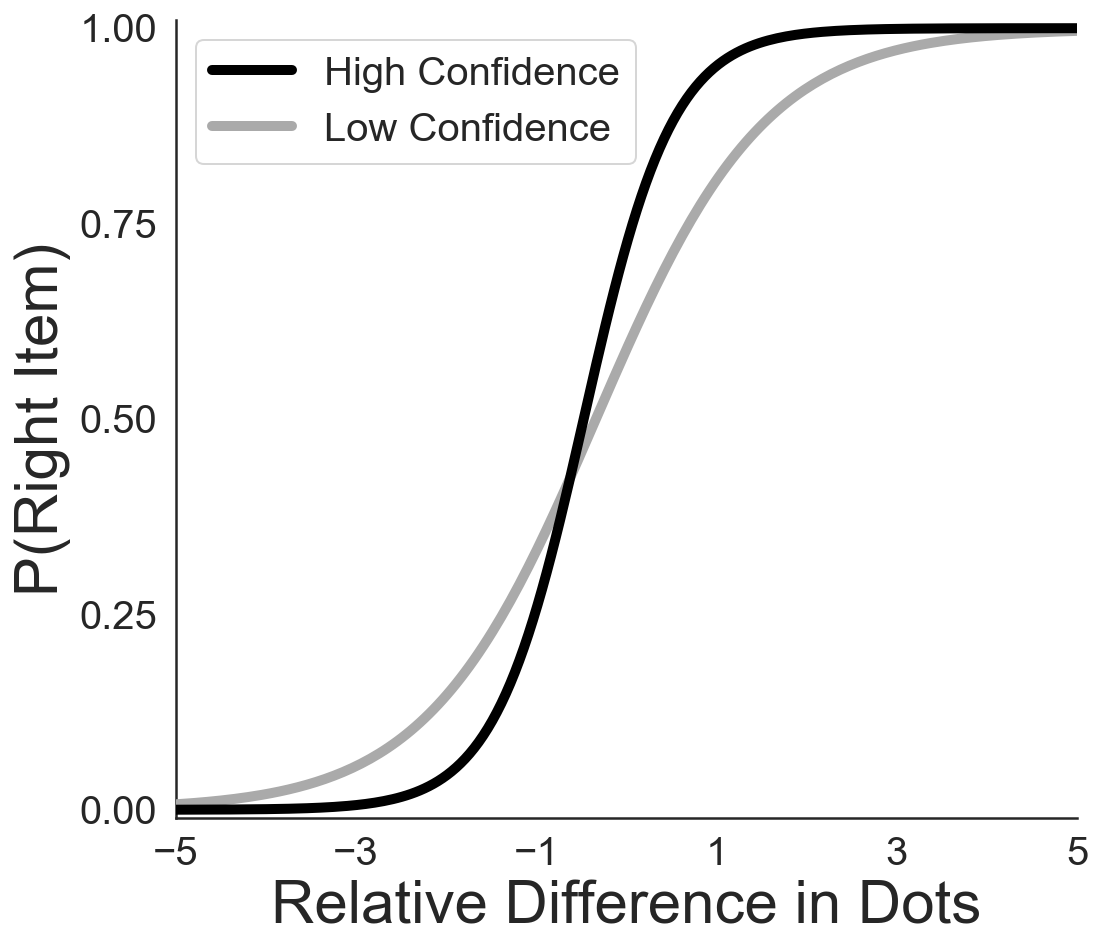

In [417]:
#redefine data_expm
data_expM= data_exp1.loc[data_exp1['BlockCond'] == 'MORE'] # 1 = Like, 2 = Dislike
data_expF= data_exp1.loc[data_exp1['BlockCond'] == 'LESS'] # 1 = Like, 2 = Dislike

# Split by high/low conf
logisticplot_simpl('ConfSplit', 'High Confidence', 'Low Confidence', data=data_expM, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Relative Difference in Dots', modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()
savefig('LogDotDif.png')

C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Low measure coef [[-0.95630481]]
High measure coef [[-1.53410878]]


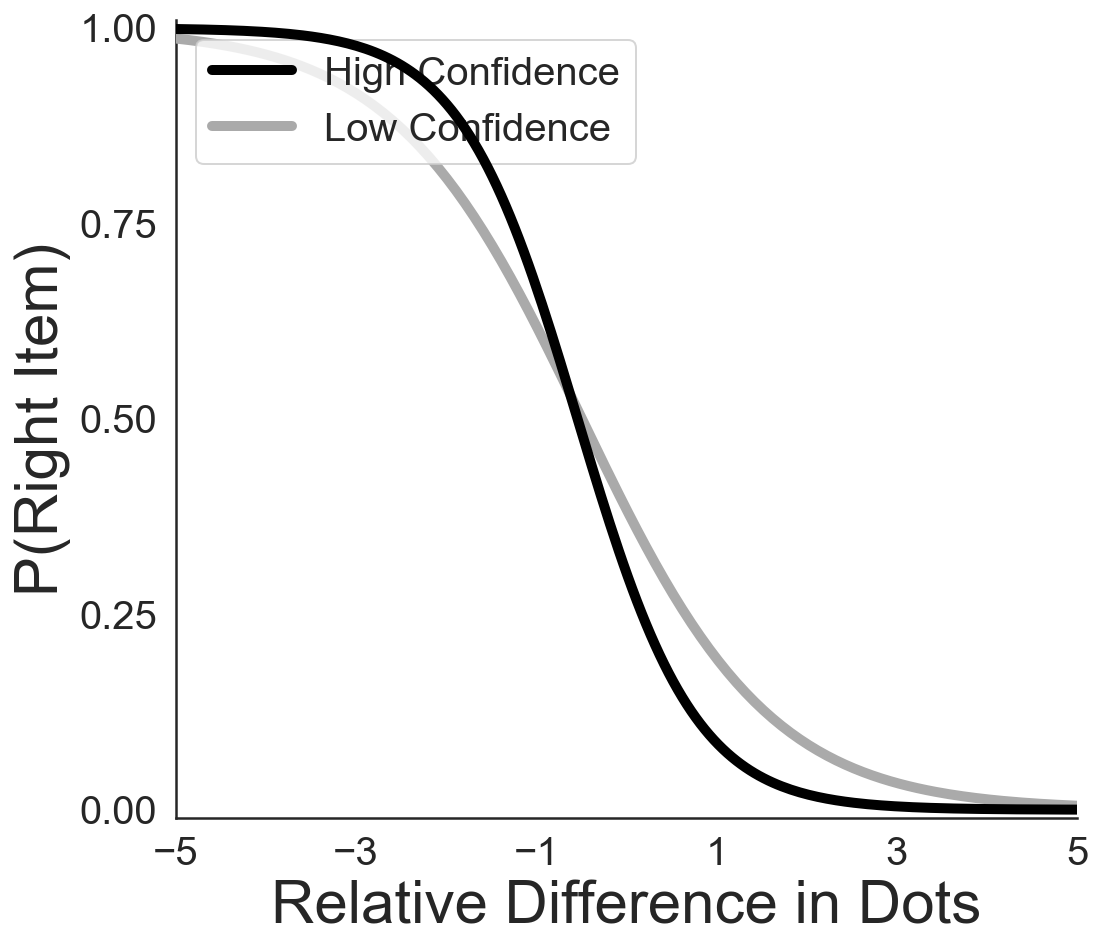

In [418]:
# Split by high/low conf
logisticplot_simpl('ConfSplit', 'High Confidence', 'Low Confidence', data=data_expF, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Relative Difference in Dots',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Low measure coef [[1.41830743]]
High measure coef [[1.53671549]]


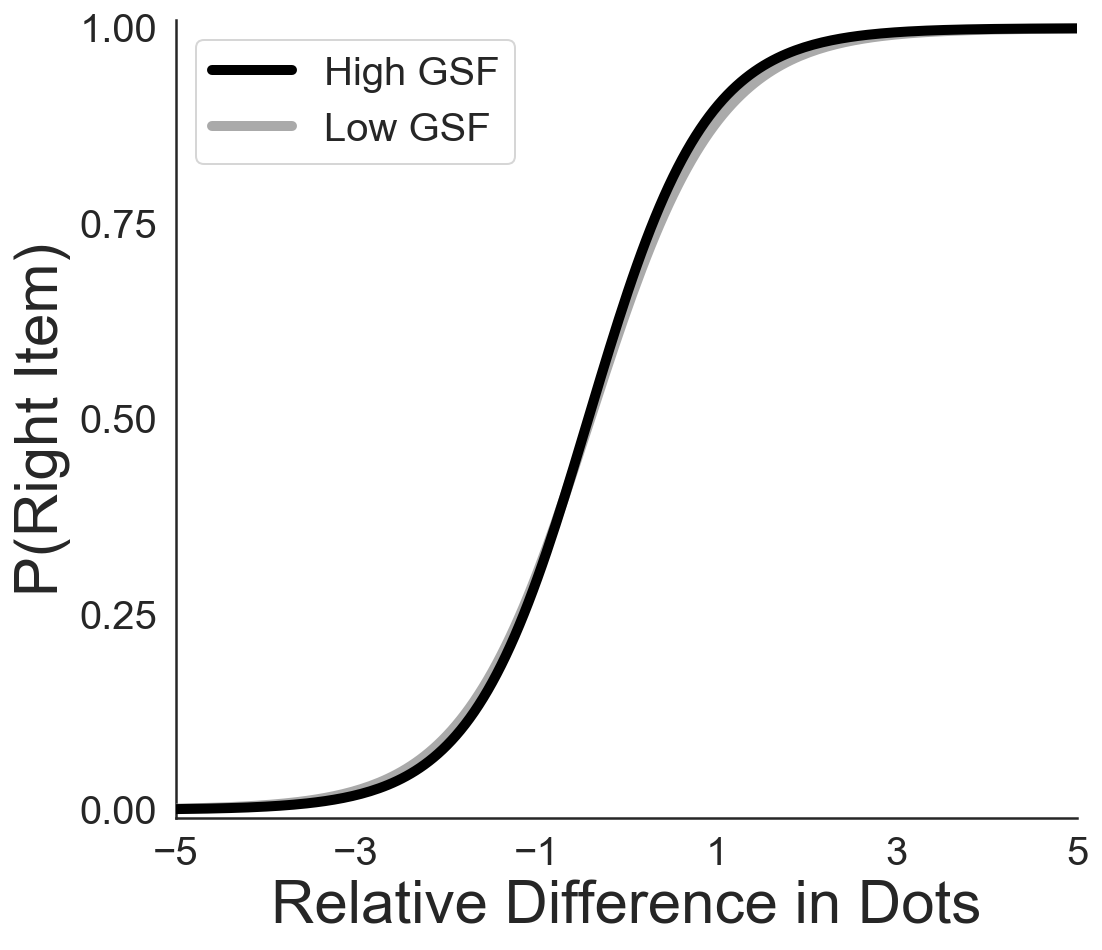

In [419]:
logisticplot_simpl('GSFMedSplit', 'High GSF', 'Low GSF', data=data_expM, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Relative Difference in Dots',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Low measure coef [[-1.20932151]]
High measure coef [[-1.24764083]]


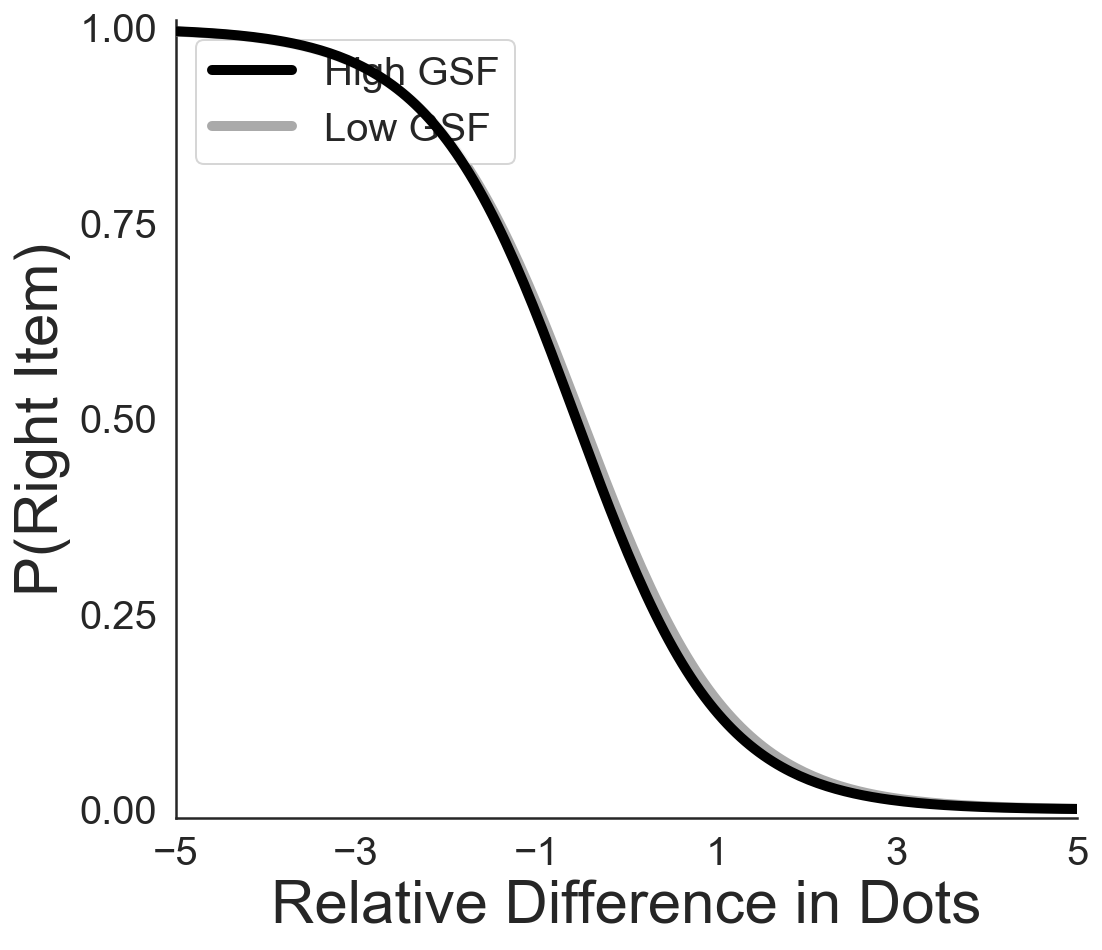

In [420]:
# Split by high/low gaze shift frequency
logisticplot_simpl('GSFMedSplit', 'High GSF', 'Low GSF', data=data_expF, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Relative Difference in Dots',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Low measure coef [[1.37581346]]
High measure coef [[1.45941132]]


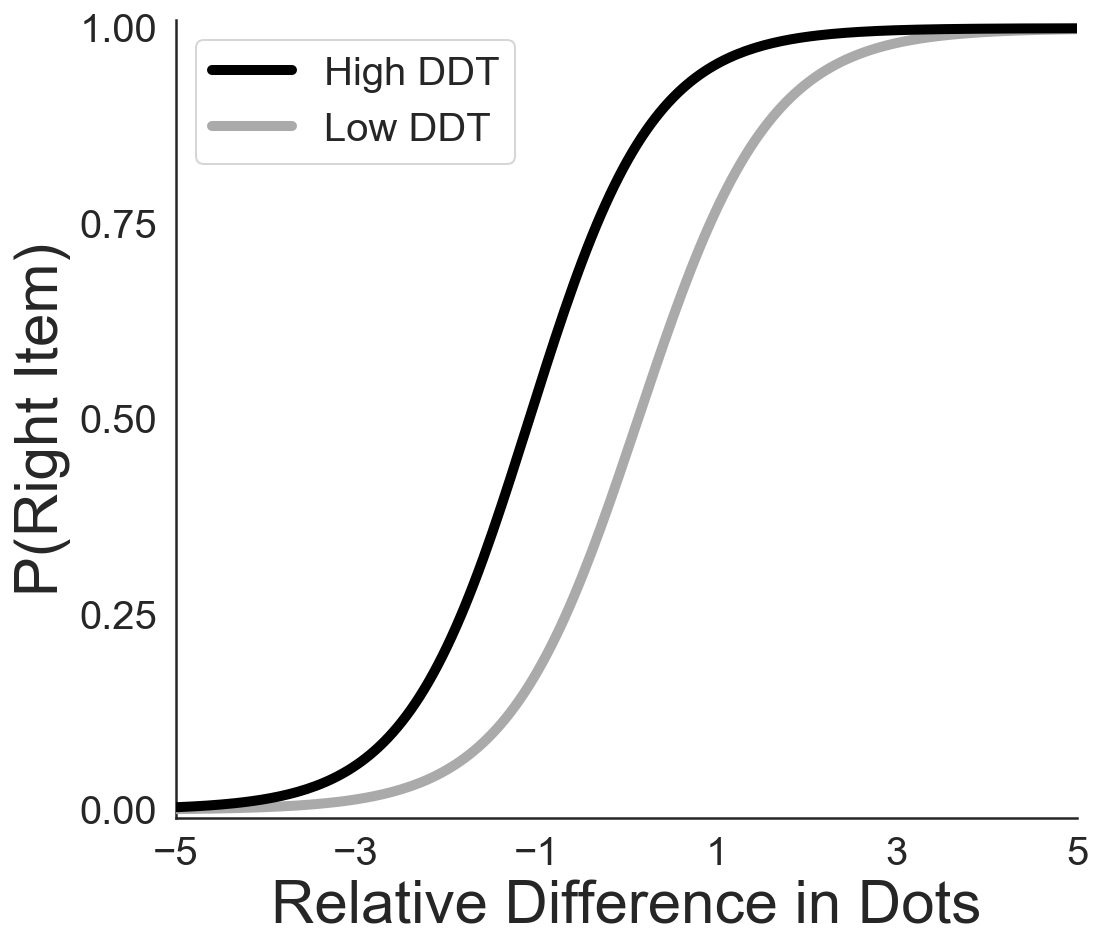

In [421]:
# Split by high/low dwelling time
logisticplot_simpl('DDTMedSplit', 'High DDT', 'Low DDT', data=data_expM, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Relative Difference in Dots',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()
savefig('LogDwellTime.png')

In [422]:
scipy.stats.ttest_ind(logit_high, logit_low)

NameError: name 'logit_high' is not defined

C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nedge\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Low measure coef [[-1.11117864]]
High measure coef [[-1.22672116]]


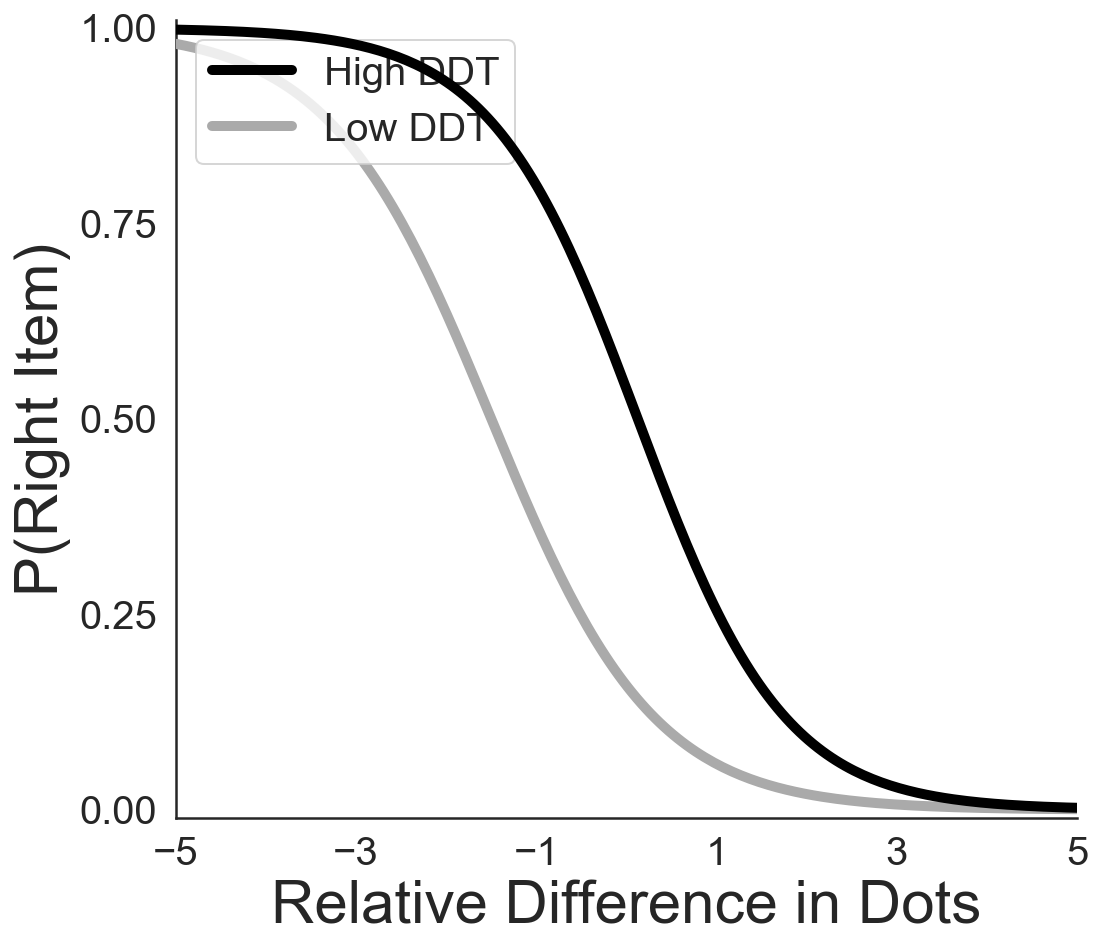

In [423]:
# Split by high/low dwelling time
logisticplot_simpl('DDTMedSplit', 'High DDT', 'Low DDT', data=data_expF, xaxis='zDV', yaxis='ChosenITM', ylab='P(Right Item)', xlab='Relative Difference in Dots',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='Part')
plt.tight_layout()

# Correlation Plots In R

In [424]:
import rpy2


%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings('ignore', category=RRuntimeWarning)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [425]:
%R -i data_exp1 #do the same as this but change i to o when we want to move variables from R to python


C:\Users\nedge\New folder\lib\site-packages\rpy2-2.9.4-py3.7-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [426]:

%%R

# Use in case the libraries are not available in the system
#install.packages('lme4')
#install.packages('car')
#install.packages('ggplot2')
#install.packages('broom')
#install.packages('arm')
#install.packages('ggplot2')
#install.packages('optimx')
#install.packages('multcomp')


library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)

In [427]:
%%R
# Separating the data for both conditions 
data_expM <- data_exp1[ which(data_exp1$BlockCond=='MORE'), ]
data_expF <- data_exp1[ which(data_exp1$BlockCond=='LESS'), ]

#Make all columns to be analysed into numerics

data_expM$zDV <- as.numeric(data_expM$zDV)
data_expF$zDV <- as.numeric(data_expF$zDV)
data_expM$zConf <- as.numeric(data_expM$zConf)
data_expF$zConf <- as.numeric(data_expF$zConf)
data_expM$ChosenITM <- as.numeric(data_expM$ChosenITM)
data_expF$ChosenITM <- as.numeric(data_expF$ChosenITM)
data_expM$RValue <- as.numeric(data_expM$RValue)
data_expF$RValue <- as.numeric(data_expF$RValue)
data_expM$LValue <- as.numeric(data_expM$LValue)
data_expF$LValue <- as.numeric(data_expF$LValue)
data_expM$zAbsDV <- as.numeric(data_expM$zAbsDV)
data_expF$zAbsDV <- as.numeric(data_expF$zAbsDV)
data_expM$zChoiceRT <- as.numeric(data_expM$zChoiceRT)
data_expF$zChoiceRT <- as.numeric(data_expF$zChoiceRT)
data_expM$ValCh <- as.numeric(data_expM$ValCh)
data_expF$ValCh <- as.numeric(data_expF$ValCh)
data_expM$ValUnCh <- as.numeric(data_expM$ValUnCh)
data_expF$ValUnCh <- as.numeric(data_expF$ValUnCh)
data_expM$zTotVal <- as.numeric(data_expM$zTotVal)
data_expF$zTotVal <- as.numeric(data_expF$zTotVal)
data_expM$absDDT <- as.numeric(data_expM$absDDT)
data_expF$absDDT <- as.numeric(data_expF$absDDT)
data_expM$High <- as.numeric(data_expM$High)
data_expF$High <- as.numeric(data_expF$High)
data_expM$Low <- as.numeric(data_expM$Low)
data_expF$Low <- as.numeric(data_expF$Low)


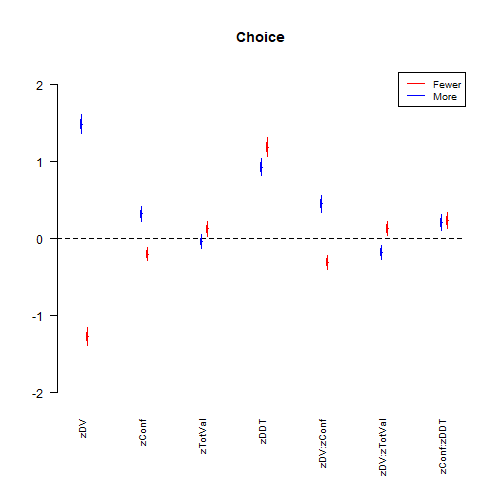

In [428]:
%%R

title_plot = 'Choice'

ModelChoiceM_1 <- glm(ChosenITM ~ zDV +  zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_expM, family=binomial(link='logit')) #zDV + 
ModelChoiceF_1 <- glm(ChosenITM ~ zDV + zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_expF, family=binomial(link='logit')) #zDV + 

coefplot(ModelChoiceM_1,intercept=FALSE,vertical = FALSE,  col.pts='blue', mar = c(3,4,5,1) ,ylim=c(-2,2) ,main=title_plot)
coefplot(ModelChoiceF_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts='red',mar = c(3,4,5,1))
legend('topright',  legend=c('Fewer', 'More'),col=c('red', 'blue'), lty=1:1, cex=0.8)

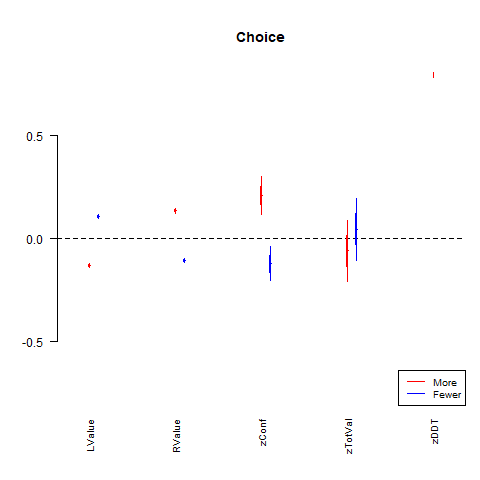

In [430]:
%%R
title_plot = ("Choice")

ModelChoiceM_3 <- glm(ChosenITM ~ LValue + RValue + zConf + zTotVal+ zDDT, data=data_expM, family=binomial(link="logit"))
ModelChoiceF_3 <- glm(ChosenITM ~  LValue + RValue + zConf + zTotVal+ zDDT, data=data_expF, family=binomial(link="logit"))

model <- coef(ModelChoiceM_3)

coefplot(ModelChoiceM_3,intercept=FALSE,vertical = FALSE,  col.pts="red", mar = c(3,4,5,1) ,ylim=c(-0.75, 0.75) ,main=title_plot)
coefplot(ModelChoiceF_3, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1))
legend("bottomright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=0.8)
print(data_expM$RValue)

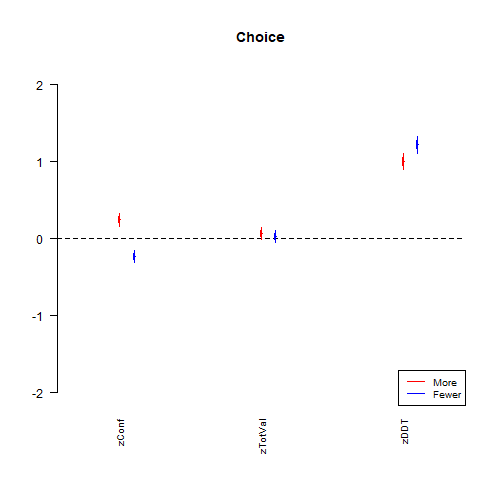

In [431]:
%%R

title_plot = ("Choice")

ModelChoiceM_4 <- glm(ChosenITM ~ zConf + zTotVal+ zDDT, data=data_expM, family=binomial(link="logit"))
ModelChoiceF_4 <- glm(ChosenITM ~ zConf + zTotVal + zDDT, data=data_expF, family=binomial(link="logit"))

coefplot(ModelChoiceM_4,intercept=FALSE,vertical = FALSE, col.pts="red", mar = c(3,4,5,1) ,ylim=c(-2, 2) ,main=title_plot)
coefplot(ModelChoiceF_4, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1))
legend("bottomright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=0.8)

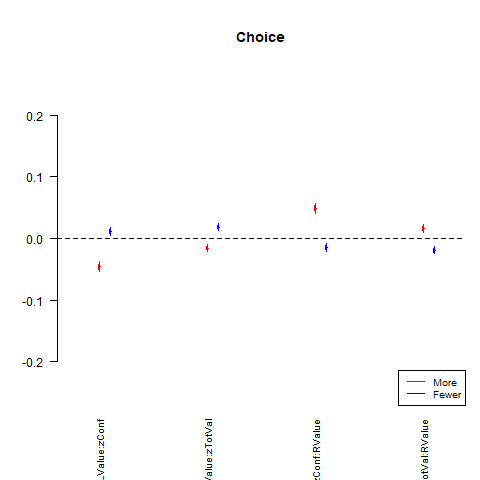

In [432]:
%%R

title_plot = ("Choice")

ModelChoiceM_4 <- glm(ChosenITM ~ LValue:zConf + LValue:zTotVal + RValue:zConf + RValue:zTotVal, data=data_expM, family=binomial(link="logit")) # LValue + RValue + zConf + zTotVal+ zDDT +
ModelChoiceF_4 <- glm(ChosenITM ~ LValue:zConf + LValue:zTotVal + RValue:zConf + RValue:zTotVal, data=data_expF, family=binomial(link="logit")) #LValue + RValue + zConf + zTotVal + zDDT +


coefplot(ModelChoiceM_4,intercept=FALSE,vertical = FALSE,  col.pts="red", mar = c(3,4,5,1) ,ylim=c(-0.25, 0.25) ,main=title_plot)
coefplot(ModelChoiceF_4, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1))
legend("bottomright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=0.8)

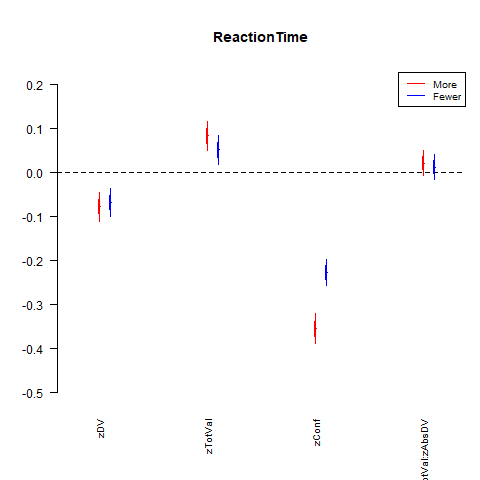

In [433]:
%%R
# Figure replicating Folke 2016. 
title_plot = ("ReactionTime")

ModelConfidenceM_1 <- glm(zChoiceRT ~ zDV  + zTotVal + zConf + zAbsDV:zTotVal, data=data_expM) # + zGSF 
ModelConfidenceF_1 <- glm(zChoiceRT ~ zDV + zTotVal + zConf+ zAbsDV:zTotVal, data=data_expF) #  + zGSF 

#summary(logitMod_FF2017)
#summary(logitModLike_FF2017)
#summary(logitModUnlike_FF2017)

coefplot(ModelConfidenceM_1, intercept=FALSE, vertical = FALSE, col.pts="red", offset = 0.05, mar = c(3,4,5,1),ylim=c(-0.5, 0.2) ,main=title_plot)
coefplot(ModelConfidenceF_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1),main="RegEstim")
legend("topright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=0.8)

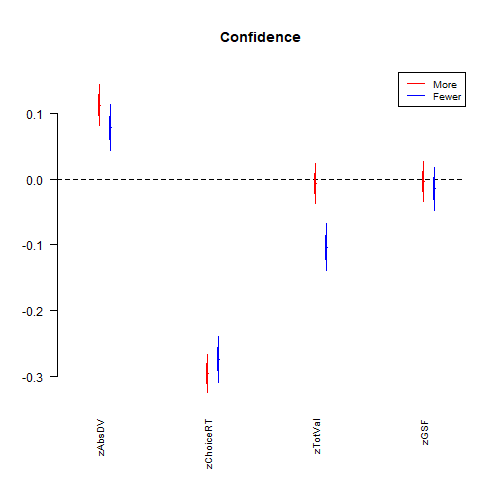

In [434]:
%%R

data_expM34 <- data_expM
# Figure replicating Folke 2016. 
title_plot = ("Confidence")

ModelConfidenceM_1 <- glm(zConf ~ zAbsDV + zChoiceRT + zTotVal + zGSF, data=data_expM) # + zGSF  + BaseCode
ModelConfidenceF_1 <- glm(zConf ~ zAbsDV + zChoiceRT + zTotVal+ zGSF, data=data_expF) #  + zGSF + BaseCode

#summary(logitMod_FF2017)
#summary(logitModLike_FF2017)
#summary(logitModUnlike_FF2017)

coefplot(ModelConfidenceM_1, intercept=FALSE, vertical = FALSE, col.pts="red", offset = 0.05, mar = c(3,4,5,1) ,main=title_plot)
coefplot(ModelConfidenceF_1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue",mar = c(3,4,5,1),main="RegEstim")
legend("topright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=0.8)

## Separating by participant

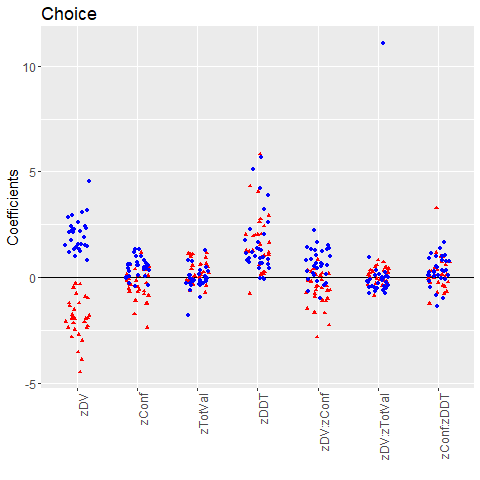

In [435]:
%%R
#Run for all the participants

#Define number of regressors to use
numCol = 7
# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)

for (i in unique(data_expM[,"Part"])){
    data_rgrs_subj  <- data_expM[ which(data_expM$Part==i), ]
    rsults <- glm(ChosenITM ~ zDV + zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
    # To avoid plotting the intercept
    partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameMore <- data.frame(partCoefs)

#extract the name of the coefficients
a <- names (rsults$coefficients)

#replace names for coefficients in dataframe
for (j in 2: length(a)){
    colnames(CoefsDataFrameMore)[j-1] <- a[j]
}
CoefsDataFrameMore

#print(rsults)
#print(CoefsDataFrameLike)

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)
for (i in unique(data_expF[,"Part"])){
    data_rgrs_subj  <- data_expF[ which(data_expF$Part==i), ]
    rsults <- glm(ChosenITM ~ zDV + zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
    # To avoid plotting the intercept
    partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameFewer <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
    colnames(CoefsDataFrameFewer)[j-1] <- a[j]
}

CoefsDataFrameFewer

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameFewer),aes(x=variable, y=value), shape = 17, color='red', position = jitter) +
      geom_point(data = melt(CoefsDataFrameMore), aes(x=variable, y=value),color='blue', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Choice") + theme(legend.position="Top",text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1))



#save as an image
#ggsave("Output/Choice_Reg_Participant.tiff", units="in", width=6, height=4, dpi=300, compression = 'lzw')
plot2

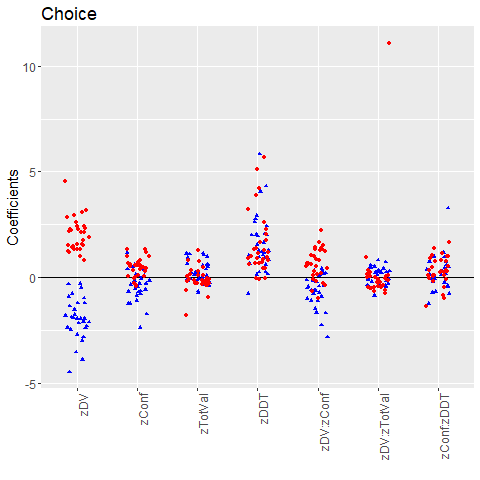

In [436]:
%%R
#Run for all the participants

#Define number of regressors to use
numCol = 7
# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)

for (i in unique(data_expM[,"Part"])){
    data_rgrs_subj  <- data_expM[ which(data_expM$Part==i), ]
    rsults <- glm(ChosenITM ~ zDV + zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
    # To avoid plotting the intercept
    partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameMore <- data.frame(partCoefs)

#extract the name of the coefficients
a <- names (rsults$coefficients)

#replace names for coefficients in dataframe
for (j in 2: length(a)){
    colnames(CoefsDataFrameMore)[j-1] <- a[j]
}
CoefsDataFrameMore

#print(rsults)
#print(CoefsDataFrameLike)

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)
for (i in unique(data_expF[,"Part"])){
    data_rgrs_subj  <- data_expF[ which(data_expF$Part==i), ]
    rsults <- glm(ChosenITM ~ zDV + zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_rgrs_subj, family=binomial(link="logit"))
    # To avoid plotting the intercept
    partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameFewer <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
    colnames(CoefsDataFrameFewer)[j-1] <- a[j]
}

CoefsDataFrameFewer

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameFewer),aes(x=variable, y=value), shape = 17, color='blue', position = jitter) +
      geom_point(data = melt(CoefsDataFrameMore), aes(x=variable, y=value),color='red', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Choice") + theme(legend.position="Top",text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1))



#save as an image
#ggsave("Output/Choice_Reg_Participant.tiff", units="in", width=6, height=4, dpi=300, compression = 'lzw')
plot2

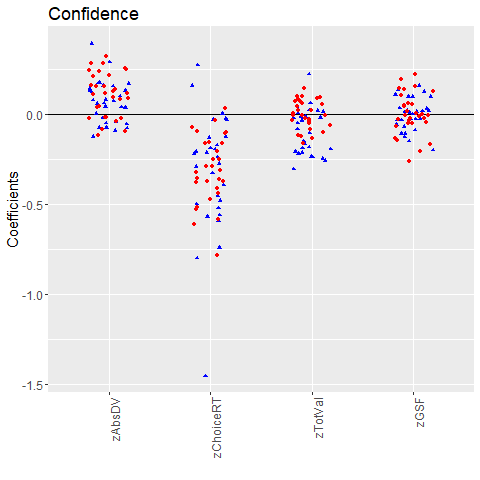

In [437]:
%%R
#Generate regression plots for individual participants 

#Run for all the participants
numCol = 4
# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)
for (i in unique(data_expM[,"Part"])){
data_rgrs_subj  <- data_expM[ which(data_expM$Part==i), ]
rsults <- glm(zConf ~ zAbsDV + zChoiceRT  + zTotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameMore <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameMore)[j-1] <- a[j]
}
CoefsDataFrameMore

#print(rsults)
#print(CoefsDataFrameLike)



# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)
for (i in unique(data_expF[,"Part"])){
data_rgrs_subj  <- data_expF[ which(data_expF$Part==i), ]
rsults <- glm(zConf ~ zAbsDV + zChoiceRT  + zTotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameFewer <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameFewer)[j-1] <- a[j]
}
CoefsDataFrameFewer

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameFewer),aes(x=variable, y=value), shape = 17, color='blue', position = jitter) +
      geom_point(data = melt(CoefsDataFrameMore), aes(x=variable, y=value),color='red', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Confidence") + theme(legend.position="Top",text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1))
      
#ggsave("Output/Confidence_Reg_Participant.tiff", units="in", width=5, height=4, dpi=300, compression = 'lzw')

plot2

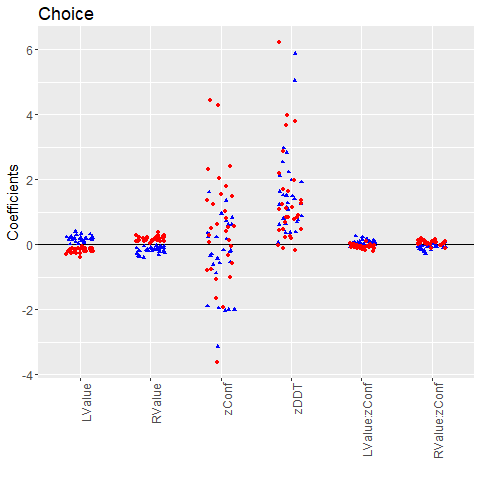

In [438]:

%%R
#Run for all the participants

#Define number of regressors to use
numCol = 6
# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)

for (i in unique(data_expM[,"Part"])){
    data_rgrs_subj  <- data_expM[ which(data_expM$Part==i), ]
    rsults <- glm(ChosenITM ~ LValue + RValue + zConf + zDDT + LValue:zConf  + RValue:zConf  , data=data_rgrs_subj, family=binomial(link="logit"))
    # To avoid plotting the intercept
    partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])   
   #print (rsults)
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameMore <- data.frame(partCoefs)

#extract the name of the coefficients
a <- names (rsults$coefficients)

#replace names for coefficients in dataframe
for (j in 2: length(a)){
    colnames(CoefsDataFrameMore)[j-1] <- a[j]
}
CoefsDataFrameMore

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)
for (i in unique(data_expF[,"Part"])){
    data_rgrs_subj  <- data_expF[ which(data_expF$Part==i), ]
    rsults <- glm(ChosenITM ~ LValue + RValue + zConf + zDDT + LValue:zConf  + RValue:zConf, data=data_rgrs_subj, family=binomial(link="logit"))
    # To avoid plotting the intercept
    partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameFewer <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)

#replace names for coefficients in dataframe
for (j in 2: length (a)){
    colnames(CoefsDataFrameFewer)[j-1] <- a[j]
}

CoefsDataFrameFewer

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameFewer),aes(x=variable, y=value), shape = 17, color='blue', position = jitter) +
      geom_point(data = melt(CoefsDataFrameMore), aes(x=variable, y=value),color='red', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Choice") + theme(legend.position="Top",text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1))

#save as an image
#ggsave("Output/Choice_Reg_Participant.tiff", units="in", width=6, height=4, dpi=300, compression = 'lzw')
plot2

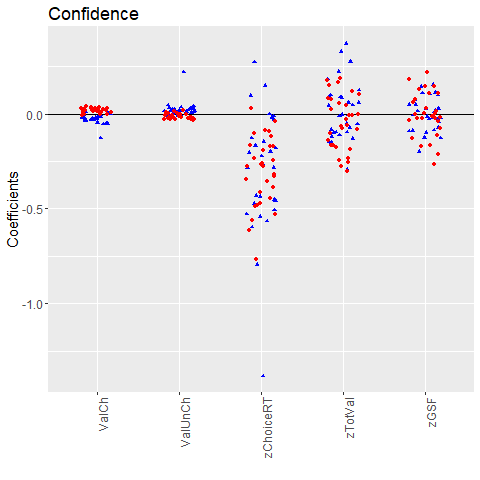

In [439]:
%%R
#Generate regression plots for individual participants 

#Run for all the participants
#Select the number of columns that correspond to actual parameter if not the matrix (and the figure) will include the values for the std errors
numCol = 5
# Extract values for LIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)
for (i in unique(data_expM[,"Part"])){
data_rgrs_subj  <- data_expM[ which(data_expM$Part==i), ]
rsults <- glm(zConf ~  ValCh + ValUnCh + zChoiceRT + zTotVal+ zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}

#transform coefficiencts by participant vector to dataframe
CoefsDataFrameMore <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameMore)[j-1] <- a[j]
}
CoefsDataFrameMore

#print(rsults)
#print(CoefsDataFrameLike)

# Extract values for DISLIKE Regression
#Initialize the matrix
partCoefs <- matrix(, nrow = 0, ncol = numCol)
for (i in unique(data_expF[,"Part"])){
data_rgrs_subj  <- data_expF[ which(data_expF$Part==i), ]
rsults <- glm(zConf ~  ValCh + ValUnCh + zChoiceRT + zTotVal + zGSF, data=data_rgrs_subj)
#print(summary(rsults)$coefficients )
partCoefs <- rbind(partCoefs,summary(rsults)$coefficients[2:(numCol+1)])      
}
#transform coefficiencts by participant vector to dataframe
CoefsDataFrameFewer <- data.frame(partCoefs)
#extract the name of the coefficients
a <- names (rsults$coefficients)
#replace names for coefficients in dataframe
for (j in 2: length (a)){
colnames(CoefsDataFrameFewer)[j-1] <- a[j]
}
CoefsDataFrameFewer

jitter <- position_jitter(width = 0.2)
plot2 <- ggplot()  + geom_hline(yintercept = 0) + 
      geom_point(data = melt(CoefsDataFrameFewer),aes(x=variable, y=value), shape = 17, color='blue', position = jitter) +
      geom_point(data = melt(CoefsDataFrameMore), aes(x=variable, y=value),color='red', position = jitter) + labs(x = "", y = "Coefficients") +
      ggtitle("Confidence") + theme(legend.position="Top",text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1))
#ggsave("Output/Confidence_Reg_Participant.tiff", units="in", width=5, height=4, dpi=300, compression = 'lzw')

plot2

## Using BIC

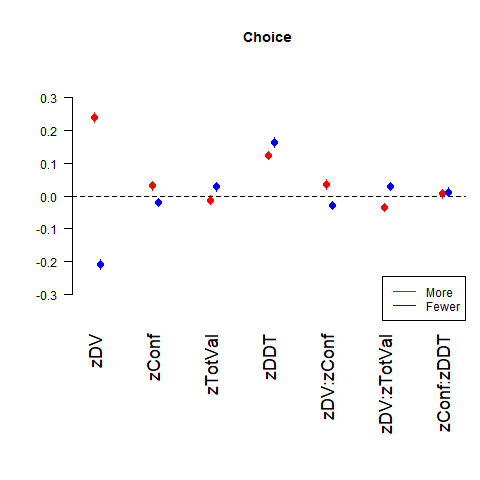

In [440]:
%%R
#regression for confidence and familiarity
title_plot = ("Choice")

ModelChoiceM1 <- glm(ChosenITM ~ zDV +  zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_expM) #zDV + 
ModelChoiceF1 <- glm(ChosenITM ~ zDV + zConf + zTotVal + zDV:zConf + zDV:zTotVal + zDDT + zConf:zDDT, data=data_expF) #zDV + 


BIC1 = BIC(ModelChoiceM1)
BIC2 = BIC(ModelChoiceF1)
print("More BIC:")
print(BIC1)
print("Fewer BIC:")
print(BIC2)

coefplot(ModelChoiceM1,intercept=FALSE, vertical = FALSE, col.pts="red", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(10,5,5,1), ylim=c(-0.35, 0.35), main=title_plot) 
coefplot(ModelChoiceF1, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(10,5,5,1),main="RegEstim") 

legend("bottomright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=1)

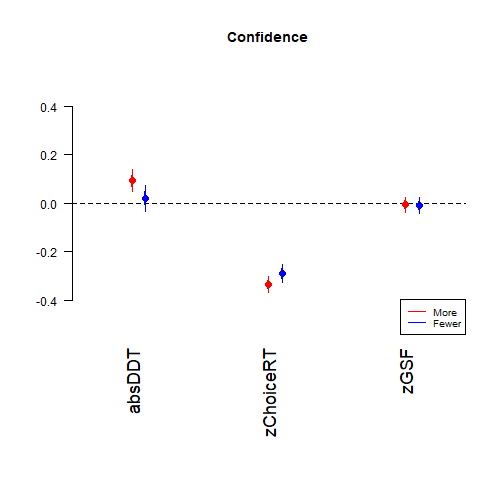

In [441]:
%%R
#regression for confidence and familiarity
title_plot = ("Confidence")

ModelConfidenceM2 <- glm(zConf ~ absDDT + zChoiceRT  +  zGSF  , data=data_expM)
ModelConfidenceF2 <- glm(zConf ~ absDDT + zChoiceRT  +  zGSF , data=data_expF)

BIC1 = BIC(ModelConfidenceM2)
BIC2 = BIC(ModelConfidenceF2)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelConfidenceM2,intercept=FALSE, vertical = FALSE, col.pts="red", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(10,5,5,1), ylim=c(-0.5, 0.5), main=title_plot)
coefplot(ModelConfidenceF2, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(10,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=0.8)

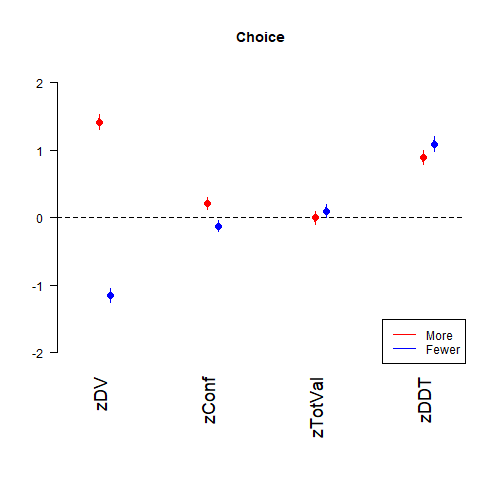

In [442]:
%%R
# regression for choice and familiarity
title_plot = "Choice"

ModelChoiceM <- glm(ChosenITM ~ zDV + zConf + zTotVal + zDDT , data=data_expM, family=binomial(link="logit"))
ModelChoiceF <- glm(ChosenITM ~ zDV + zConf + zTotVal+ zDDT, data=data_expF, family=binomial(link="logit"))

BIC1 = BIC(ModelChoiceM)
BIC2 = BIC(ModelChoiceF)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelChoiceM,intercept=FALSE,vertical = FALSE,  col.pts="red" , cex.var=1.5, cex.pts=2, mar = c(8,4,5,1) ,ylim=c(-2,2) ,main=title_plot)
coefplot(ModelChoiceF, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="blue", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1))
legend("bottomright",  legend=c("More", "Fewer"),col=c("red", "blue"), lty=1:1, cex=1)

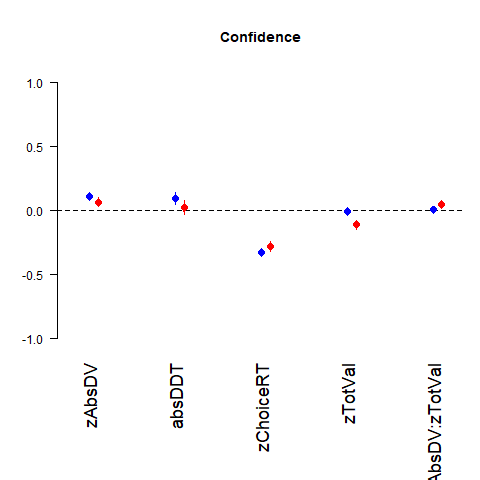

In [444]:
%%R

#RT GSF Corr High Low

#data_expM45 <- data_expM[ which(data_exp1$BaseCode=='0'), ]
#data_expF45 <- data_expF[ which(data_exp1$BaseCode=='0'), ]
#data_expM80 <- data_expM[ which(data_exp1$BaseCode=='1'), ]
#data_expF80 <- data_expF[ which(data_exp1$BaseCode=='1'), ]
#data_expM115 <- data_expM[ which(data_exp1$BaseCode=='2'), ]
#data_expF115 <- data_expF[ which(data_exp1$BaseCode=='2'), ]


#attach(mtcars)
#par(mfrow=c(1,3))

#regression for confidence and familiarity
title_plot = ("Confidence")

ModelConfidenceMi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expM)
ModelConfidenceFi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expF)

BIC1 = BIC(ModelConfidenceMi)
BIC2 = BIC(ModelConfidenceFi)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-1,1), main=title_plot)
coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
#legend("bottomright",  legend=c("Fewer", "More"),col=c("red", "blue"), lty=1:1, cex=1)

#title_plot = ("Confidence")

#ModelConfidenceMi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expM80)
#ModelConfidenceFi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expF80)

#BIC1 = BIC(ModelConfidenceMi)
#BIC2 = BIC(ModelConfidenceFi)
#print("Like BIC:")
#print(BIC1)
#print("DisLike BIC:")
#print(BIC2)

#coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-0.4,0.2), main=title_plot)
#coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
#legend("bottomright",  legend=c("Fewer", "More"),col=c("red", "blue"), lty=1:1, cex=1)

#title_plot = ("Confidence")

#ModelConfidenceMi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expM45)
#ModelConfidenceFi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expF45)

#BIC1 = BIC(ModelConfidenceMi)
#BIC2 = BIC(ModelConfidenceFi)
#print("Like BIC:")
#print(BIC1)
#print("DisLike BIC:")
#print(BIC2)

#coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-0.4,0.2), main=title_plot)
#coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
#legend("bottomright",  legend=c("Fewer", "More"),col=c("red", "blue"), lty=1:1, cex=1)'''

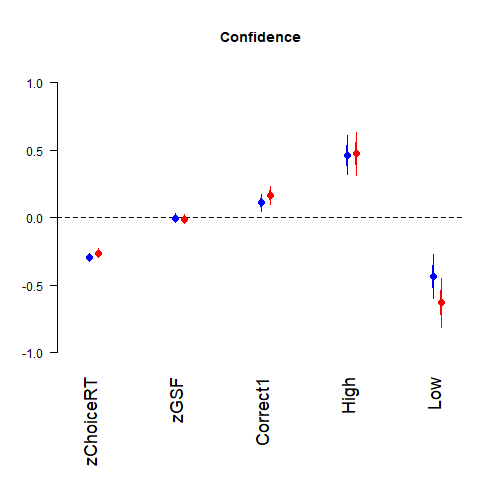

In [445]:
%%R
title_plot = ("Confidence")

ModelConfidenceMi <- glm(zConf ~ zChoiceRT +zGSF + Correct + High + Low, data=data_expM)
ModelConfidenceFi <- glm(zConf ~ zChoiceRT +zGSF + Correct + High + Low, data=data_expF)

BIC1 = BIC(ModelConfidenceMi)
BIC2 = BIC(ModelConfidenceFi)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-1,1), main=title_plot)
coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")

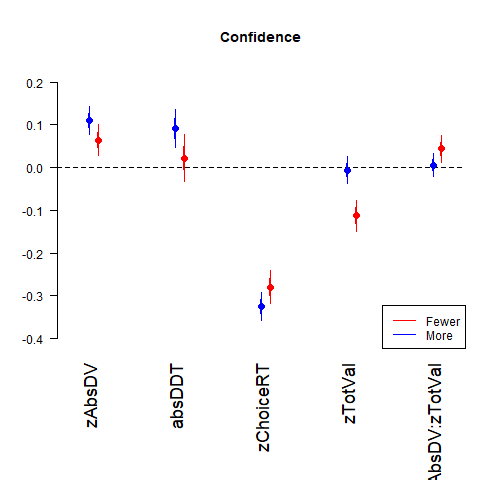

In [259]:
%%R

data_expM50 <- data_expM[ which(data_exp1$BaseCode=='0'), ]
data_expF50 <- data_expF[ which(data_exp1$BaseCode=='0'), ]
data_expM80 <- data_expM[ which(data_exp1$BaseCode=='1'), ]
data_expF80 <- data_expF[ which(data_exp1$BaseCode=='1'), ]
data_expM110 <- data_expM[ which(data_exp1$BaseCode=='2'), ]
data_expF110 <- data_expF[ which(data_exp1$BaseCode=='2'), ]

title_plot = ("Confidence")

ModelConfidenceMi <- glm(zConf ~ zAbsDV +  absDDT + zChoiceRT + zTotVal + zTotVal:zAbsDV, data=data_expM)
ModelConfidenceFi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zTotVal:zAbsDV, data=data_expF)

BIC1 = BIC(ModelConfidenceMi)
BIC2 = BIC(ModelConfidenceFi)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-0.4,0.2), main=title_plot)
coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("Fewer", "More"),col=c("red", "blue"), lty=1:1, cex=1)

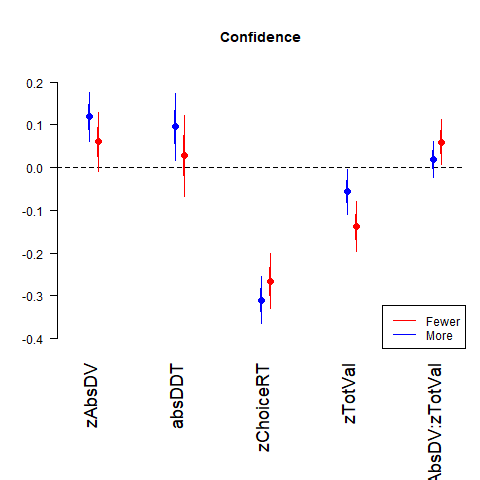

In [267]:
%%R

title_plot = ("Confidence")

ModelConfidenceMi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expM110)
ModelConfidenceFi <- glm(zConf ~ zAbsDV + absDDT + zChoiceRT + zTotVal + zAbsDV:zTotVal, data=data_expF110)

BIC1 = BIC(ModelConfidenceMi)
BIC2 = BIC(ModelConfidenceFi)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-0.4,0.2), main=title_plot)
coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("Fewer", "More"),col=c("red", "blue"), lty=1:1, cex=1)

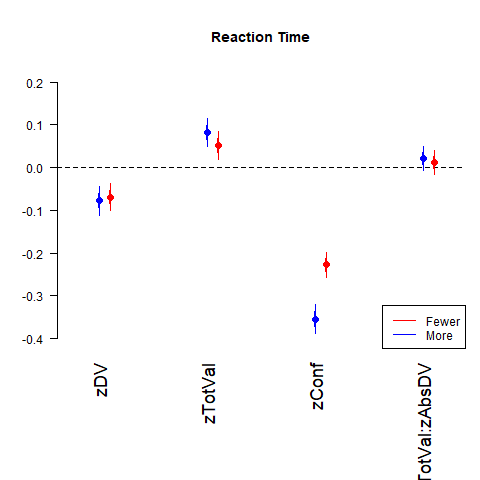

In [163]:
%%R

title_plot = ("Reaction Time")

ModelConfidenceMi <- glm(zChoiceRT ~ zDV  + zTotVal + zConf + zAbsDV:zTotVal, data=data_expM) # + zGSF 
ModelConfidenceFi <- glm(zChoiceRT ~ zDV + zTotVal + zConf+ zAbsDV:zTotVal, data=data_expF) #  + zGSF 

BIC1 = BIC(ModelConfidenceMi)
BIC2 = BIC(ModelConfidenceFi)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-0.4,0.2), main=title_plot)
coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("Fewer", "More"),col=c("red", "blue"), lty=1:1, cex=1)

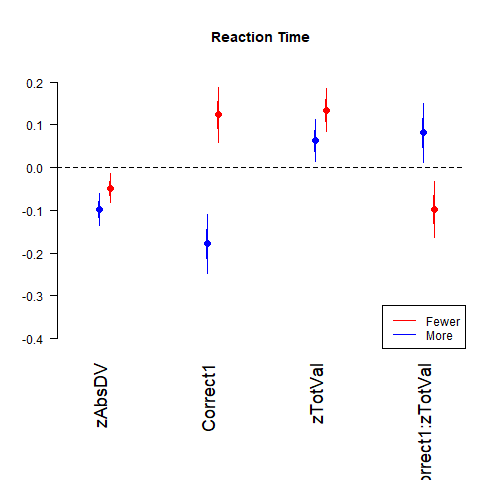

In [164]:
%%R

title_plot = ("Reaction Time")

ModelConfidenceMi <- glm(zChoiceRT ~ zAbsDV  + Correct + zTotVal + zTotVal:Correct, data=data_expM) # + zGSF
ModelConfidenceFi <- glm(zChoiceRT ~ zAbsDV + Correct+ zTotVal + zTotVal:Correct, data=data_expF) #  + zGSF

#Total Value by high and low value.

BIC1 = BIC(ModelConfidenceMi)
BIC2 = BIC(ModelConfidenceFi)
print("Like BIC:")
print(BIC1)
print("DisLike BIC:")
print(BIC2)

coefplot(ModelConfidenceMi,intercept=FALSE, vertical = FALSE, col.pts="blue", cex.var=1.5, cex.pts=2, offset = 0.05, mar = c(8,4,5,1) ,ylim=c(-0.4,0.2), main=title_plot)
coefplot(ModelConfidenceFi, intercept=FALSE, vertical = FALSE, add=TRUE, col.pts="red", cex.var=1.5, cex.pts=2,mar = c(8,4,5,1),main="RegEstim")
legend("bottomright",  legend=c("Fewer", "More"),col=c("red", "blue"), lty=1:1, cex=1)

In [243]:
data_exp1.to_csv("DataPerceptualFramingNotebook_v1.csv")

In [165]:
%R -o BIC1
%R -o BIC2

print(BIC1)
print(BIC2)

[1] 10456.42

[1] 9904.893



# Exclusion of Participants

In [167]:
ExclusionMatrix = []
#for cycle for participant
data_exp1['Part'] = pd.to_numeric(data_exp1['Part'])
data_exp1['Conf'] = pd.to_numeric(data_exp1['Conf'])
for k in range(0,30):
    ##print(k+1)
    # Checking for confidence
    participant_data = data_exp1.loc[(data_exp1['Part'] == k+1)]
    ConfidencePart =participant_data['Conf']
    
    ConfRange = max(ConfidencePart) - min(ConfidencePart)
    ConfCounts = ConfidencePart.value_counts()
    
    maxConfCounts = max(ConfCounts)
    ConfCountsTotal = sum(int(i) for i in ConfCounts.values)
    
    PropnMostFreqConf = maxConfCounts / ConfCountsTotal
    PropnRangeConf = ConfRange / 100

    
    ExclusionMatrix.append([k+1 , PropnMostFreqConf, PropnRangeConf]) 

#ExclusionMatrix=pd.DataFrame(ExclusionMatrix,columns=['Participant', 'ProportionMostFrequentBid', 'ProportionRangeBid','ProportionMostFrequentConfidence', 'ProportionRangeConfidence])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


C:\Users\nedge\New folder\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  from ipykernel import kernelapp as app


In [168]:
ExclusionMatrix

[[1, 0.2875, 1.0],
 [2, 0.24166666666666667, 0.86],
 [3, 0.4125, 0.76],
 [4, 0.2916666666666667, 0.96],
 [5, 0.225, 0.96],
 [6, 0.5666666666666667, 0.96],
 [7, 0.37916666666666665, 1.0],
 [8, 0.19166666666666668, 1.0],
 [9, 0.5166666666666667, 0.96],
 [10, 0.20416666666666666, 1.0],
 [11, 0.24166666666666667, 0.9],
 [12, 0.15833333333333333, 1.0],
 [13, 0.14583333333333334, 1.0],
 [14, 0.18828451882845187, 1.0],
 [15, 0.875, 0.56],
 [16, 0.36666666666666664, 1.0],
 [17, 0.2833333333333333, 0.8],
 [18, 0.17083333333333334, 1.0],
 [19, 0.175, 1.0],
 [20, 0.20833333333333334, 0.9],
 [21, 0.2916666666666667, 0.9],
 [22, 0.3458333333333333, 0.9],
 [23, 0.1375, 1.0],
 [24, 0.43333333333333335, 0.9],
 [25, 0.24166666666666667, 1.0],
 [26, 0.2, 1.0],
 [27, 0.19166666666666668, 0.94],
 [28, 0.24166666666666667, 0.8],
 [29, 0.15416666666666667, 1.0],
 [30, 0.30833333333333335, 1.0]]

# Check Gaze Bias

In [500]:
data_exp1['Correct'] = pd.to_numeric(data_exp1['Correct'])
data_exp1['tDDT'] = pd.to_numeric(data_exp1['tDDT'])


GazeBiascols = ['GazeBias', 'GazeBiasCor', 'GazeBiasInc','GazeBiasF', 'GazeBiasM', 'GazeBiasFinc', 'GazeBiasFcor', 'GazeBiasMinc', 'GazeBiasMcor']
GazeBias = pd.DataFrame(columns=GazeBiascols)
for i in range(len(participant)):
    
    i += 1
    GazeBias1 = data_exp1.loc[(data_exp1['Part'] == i)]
    GazeBiasCor = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['Correct'] == 1)]
    GazeBiasInc = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['Correct'] == 0)]
    GazeBiasF = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['BlockCond'] == 'LESS')]
    GazeBiasM = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['BlockCond'] == 'MORE')]
    GazeBiasFinc = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['BlockCond'] == 'LESS') & (data_exp1['Correct'] == 0)]
    GazeBiasMcor = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['BlockCond'] == 'MORE') & (data_exp1['Correct'] == 1)]
    GazeBiasMinc = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['BlockCond'] == 'MORE') & (data_exp1['Correct'] == 0)]
    GazeBiasFcor = data_exp1.loc[(data_exp1['Part'] == i) & (data_exp1['BlockCond'] == 'LESS') & (data_exp1['Correct'] == 1)]
    i -=1
    GazeBias.loc[i, ['GazeBias']] = sum(GazeBias1['tDDT'])/len(GazeBias1)
    GazeBias.loc[i, ['GazeBiasCor']] = sum(GazeBiasCor['tDDT'])/len(GazeBiasCor)
    GazeBias.loc[i, ['GazeBiasInc']] = sum(GazeBiasInc['tDDT'])/len(GazeBiasInc)
    GazeBias.loc[i, ['GazeBiasF']] = sum(GazeBiasF['tDDT'])/len(GazeBiasF)
    GazeBias.loc[i, ['GazeBiasM']] = sum(GazeBiasM['tDDT'])/len(GazeBiasM)
    GazeBias.loc[i, ['GazeBiasFinc']] = sum(GazeBiasFinc['tDDT'])/len(GazeBiasFinc)
    GazeBias.loc[i, ['GazeBiasMcor']] = sum(GazeBiasMcor['tDDT'])/len(GazeBiasMcor)
    GazeBias.loc[i, ['GazeBiasMinc']] = sum(GazeBiasMinc['tDDT'])/len(GazeBiasMinc)
    GazeBias.loc[i, ['GazeBiasFcor']] = sum(GazeBiasFcor['tDDT'])/len(GazeBiasFcor)
    
    
    

C:\Users\nedge\New folder\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars


In [501]:
GazeBias

GazeBias GazeBiasCor GazeBiasInc GazeBiasF GazeBiasM GazeBiasFinc  \
0   -478.55    -446.253        -551  -467.858  -489.242     -572.375   
1  -1335.82    -1499.88     -945.31  -988.358  -1683.28      -1043.8   
2   67.8292     112.576     6.24752      48.5   87.1583     -43.0566   
3  -76.4042    -68.3129    -93.5325  -124.342  -28.4667      -213.55   
4  -71.5208    -77.9226    -59.8471  -92.8417     -50.2      20.6739   
5  -97.3667    -91.0067    -107.967  -138.667  -56.0667         -209   
6  -320.758    -310.541    -340.084  -264.025  -377.492     -287.915   
7  -212.517    -204.685    -228.782  -187.942  -237.092     -212.767   
8  -232.125    -248.972    -208.131  -208.383  -255.867     -182.736   
9  -575.392    -592.229    -545.782  -633.258  -517.525     -596.705   
10 -112.296    -160.881    -16.9259  -187.617   -36.975     -91.0526   
11 -29.6667    -29.9548    -29.1412       -18  -41.3333     -21.1429   
12 -34.0125    -44.2849    -8.02941  -56.0833  -11.9417     -63.5882   
13 -222.791       168.6    -231.154  -310.292  -134.555     -310.292   
14 -203.508    -207.867    -196.244  -230.142  -176.875      -253.24   
15  26.5042     52.2941    -18.8506  -92.5583   145.567     -169.348   
16 -588.446    -575.696    -613.012  -515.492    -661.4     -506.237   
17 -109.713    -123.798    -76.8472   -28.425      -191     -43.2927   
18 -125.317    -116.405    -140.989  -170.617  -80.0167     -189.674   
19 -461.292    -482.946    -410.764  -393.492  -529.092     -501.914   
20 -194.667    -169.266     -243.61  -189.242  -200.092     -265.026   
21  103.671     164.117    -24.2857   73.4417     133.9     -169.487   
22  286.137     262.529     348.379   288.725    283.55      290.588   
23 -2.94167    -13.0394     8.40708  -9.21667   3.33333     -28.0794   
24 -182.508    -152.076    -241.146  -209.458  -155.558     -273.319   
25 -100.783    -50.8988    -217.181   -119.25  -82.3167     -263.024   
26 -281.596    -270.847      -307.7  -355.133  -208.058     -379.206   
27  237.533     241.708     231.271   226.233   248.833      200.455   
28 -247.542     -268.15    -200.397   -246.85  -248.233     -218.848   
29 -165.471    -172.815    -150.218  -215.192   -115.75     -165.814   

   GazeBiasFcor GazeBiasMinc GazeBiasMcor  
0        -415.6     -525.853     -474.767  
1      -965.529     -849.556     -2040.58  
2       120.925      60.6875      104.806  
3      -79.7375      36.2162     -57.3012  
4      -163.405     -154.821      0.17284  
5      -100.795     -19.5625     -80.4028  
6      -248.644     -408.194     -364.333  
7      -174.078     -248.457     -232.412  
8      -228.672     -237.391     -267.351  
9      -654.421     -493.674     -530.844  
10     -232.366      48.5814     -84.7532  
11     -16.3077     -36.9535     -43.7792  
12     -53.1163      47.5294     -35.4535  
13          NaN     -147.851        168.6  
14     -213.643         -125     -202.812  
15     -44.8243          150      143.266  
16      -519.78     -705.227     -636.026  
17     -20.7089     -121.226     -215.303  
18      -158.77     -86.3659     -76.7215  
19     -348.847     -324.541     -620.277  
20     -154.122     -225.114     -185.605  
21      190.407      124.737      138.146  
22      287.988      409.781      237.648  
23      11.6316        54.38     -33.1286  
24     -168.342     -197.943     -138.106  
25     -44.6329     -156.548     -56.4607  
26     -345.616     -240.167     -194.298  
27      241.158      257.346      242.324  
28     -264.257     -168.963     -271.247  
29     -242.766     -131.057     -109.447

In [492]:
def ttestsPlot(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "More", lab2 = "Fewer",title = ''):

    # t-TEST
    diff = mean(data1) - mean(data2)
    [s, p] = stats.ttest_rel(data1,data2)
    print ("ChoiceSlopes: MeanL = "+ str(mean(data1))+ "; MeanD = "+ str(mean(data2))+"; [Like - Dislike] =  " + str(diff) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(p) )
    
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(data1))    
    plt.scatter([1]*len(data1)+jittr, data1, c= c1, alpha=0.7,label=lab1)
    plt.scatter([2]*len(data2)+jittr, data2, c= c2, alpha=0.7,label=lab2)
    
    ## add lines between slope points in like and dislike for each participant
    
    for i in range(len(data1)):
        plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)
        if data1[i]<data2[i]:
            print ("Participants with slope in Like < Dislike: " + str(i))
            
    
    #legend(loc = 'best')
    plt.xticks([1, 2,], [lab1, lab2],fontsize=18)
    plt.ylabel(title, fontsize=18)
    sns.despine()

ChoiceSlopes: MeanL = -188.86932072829134; MeanD = -193.86111111111111; [Like - Dislike] =  4.991790382819772; t =  0.17 ; p-value =0.8673192058036258
Participants with slope in Like < Dislike: 0
Participants with slope in Like < Dislike: 1
Participants with slope in Like < Dislike: 6
Participants with slope in Like < Dislike: 7
Participants with slope in Like < Dislike: 8
Participants with slope in Like < Dislike: 11
Participants with slope in Like < Dislike: 16
Participants with slope in Like < Dislike: 17
Participants with slope in Like < Dislike: 19
Participants with slope in Like < Dislike: 20
Participants with slope in Like < Dislike: 22
Participants with slope in Like < Dislike: 28


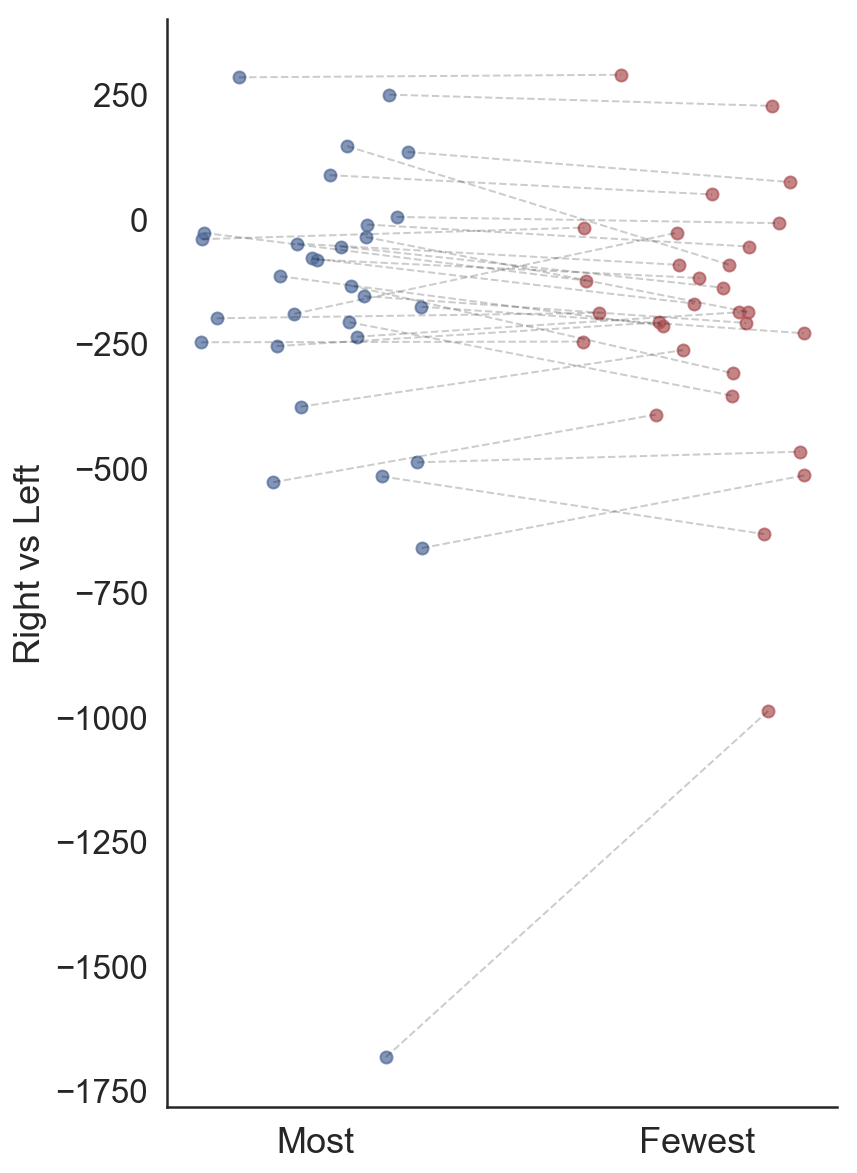

In [506]:
ttestsPlot(GazeBias['GazeBiasM'], GazeBias['GazeBiasF'],'#4F6A9A','#AC5255',"Most",  "Fewest",title = 'Right vs Left')